In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
sns.set(font_scale = 1.5)

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
buoy_data = pd.read_csv('../data-sources/forecasting-floats/cleaned-buoy-data.csv')

In [4]:
def plot_autocorrs(data, buoy_id, feature, test_size, lags, alpha=0.05):
    se = stats.norm().ppf(1-alpha/2)/np.sqrt(len(data[data['Spot Id'] == buoy_id][feature][:-test_size][1:-2]))
    fig, ax = plt.subplots(nrows=2, figsize=(15, 8), sharey=True)
    plot_acf(data[data['Spot Id'] == buoy_id][feature][:-test_size][1:-2], lags=lags, alpha=alpha, ax=ax[0])
    ax[0].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)
    ax[0].set_title(f'{feature} Autocorrelation')
    plot_pacf(data[data['Spot Id'] == buoy_id][feature][:-test_size][1:-2], lags=lags, alpha=alpha, ax=ax[1], method='ywmle')
    ax[1].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)
    ax[1].set_title(f'{feature} Partial Autocorrelation')
    plt.show()

In [5]:
def plot_diff(data, buoy_id, test_size, feature):
    fig, ax = plt.subplots(nrows=3, figsize=(15, 12))
    data[data['Spot Id'] == buoy_id][feature][:-test_size].plot(kind='line', color=['crimson'], lw=2, ax=ax[0])
    ax[0].set_title(f'{feature}')
    data[data['Spot Id'] == buoy_id][feature][:-test_size].diff()[1:].plot(kind='line', color=['crimson'], lw=2, ax=ax[1])
    ax[1].set_title(f'{feature} Differenced Once')
    data[data['Spot Id'] == buoy_id][feature][:-test_size].diff().diff()[2:].plot(kind='line', color=['crimson'], lw=2, ax=ax[2])
    ax[2].set_title(f'{feature} Differenced Twice')
    plt.show()

In [6]:
def make_predict(data, buoy_id, feature, order, start_p, end_p, exog_features=[]):
    endog = data[data['Spot Id'] == buoy_id][feature].reset_index(drop=True)
    if exog_features != []:
        exog = data[data['Spot Id'] == buoy_id][exog_features].reset_index(drop=True)
        
        model = sm.tsa.statespace.SARIMAX(endog=endog[:-end_p], exog=exog[:-end_p], order=order, trend='c')
        results = model.fit(maxiter=5000)
        print(results.summary())
    
        preds = results.predict(start=0, end=len(endog[:-end_p])+end_p, exog=exog[-(end_p+1):], dynamic=False)
        ci = results.get_prediction(start=-120, end=len(endog)+end_p, exog=exog[-(end_p*2+1):]).conf_int(alpha=0.05)
    
    else:
        model = sm.tsa.statespace.SARIMAX(endog=endog[:-end_p],order=order, trend='c')
        results = model.fit(maxiter=5000)
        print(results.summary())
    
        preds = results.predict(start=0, end=len(endog[:-end_p])+end_p, dynamic=False)
        ci = results.get_prediction(start=-120, end=len(endog)+end_p).conf_int(alpha=0.05)
    
    fig, ax = plt.subplots(figsize=(15, 8))
    endog[-168:-end_p+1].plot(c='b', label=f'Training {feature}', lw=5, ax=ax)
    endog[-end_p:].plot(c='k', label=f'Testing {feature}', lw=5, ax=ax)
    preds[-168:].plot(c='g', ls='--', lw=2.5, label='Non-dynamical Foreacasting', ax=ax)
    ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:, 1], alpha=0.3)
    plt.legend(loc=[1.1, 0])
    results.plot_diagnostics(figsize=(15, 15))
    print(preds[-10:])
    plt.show()

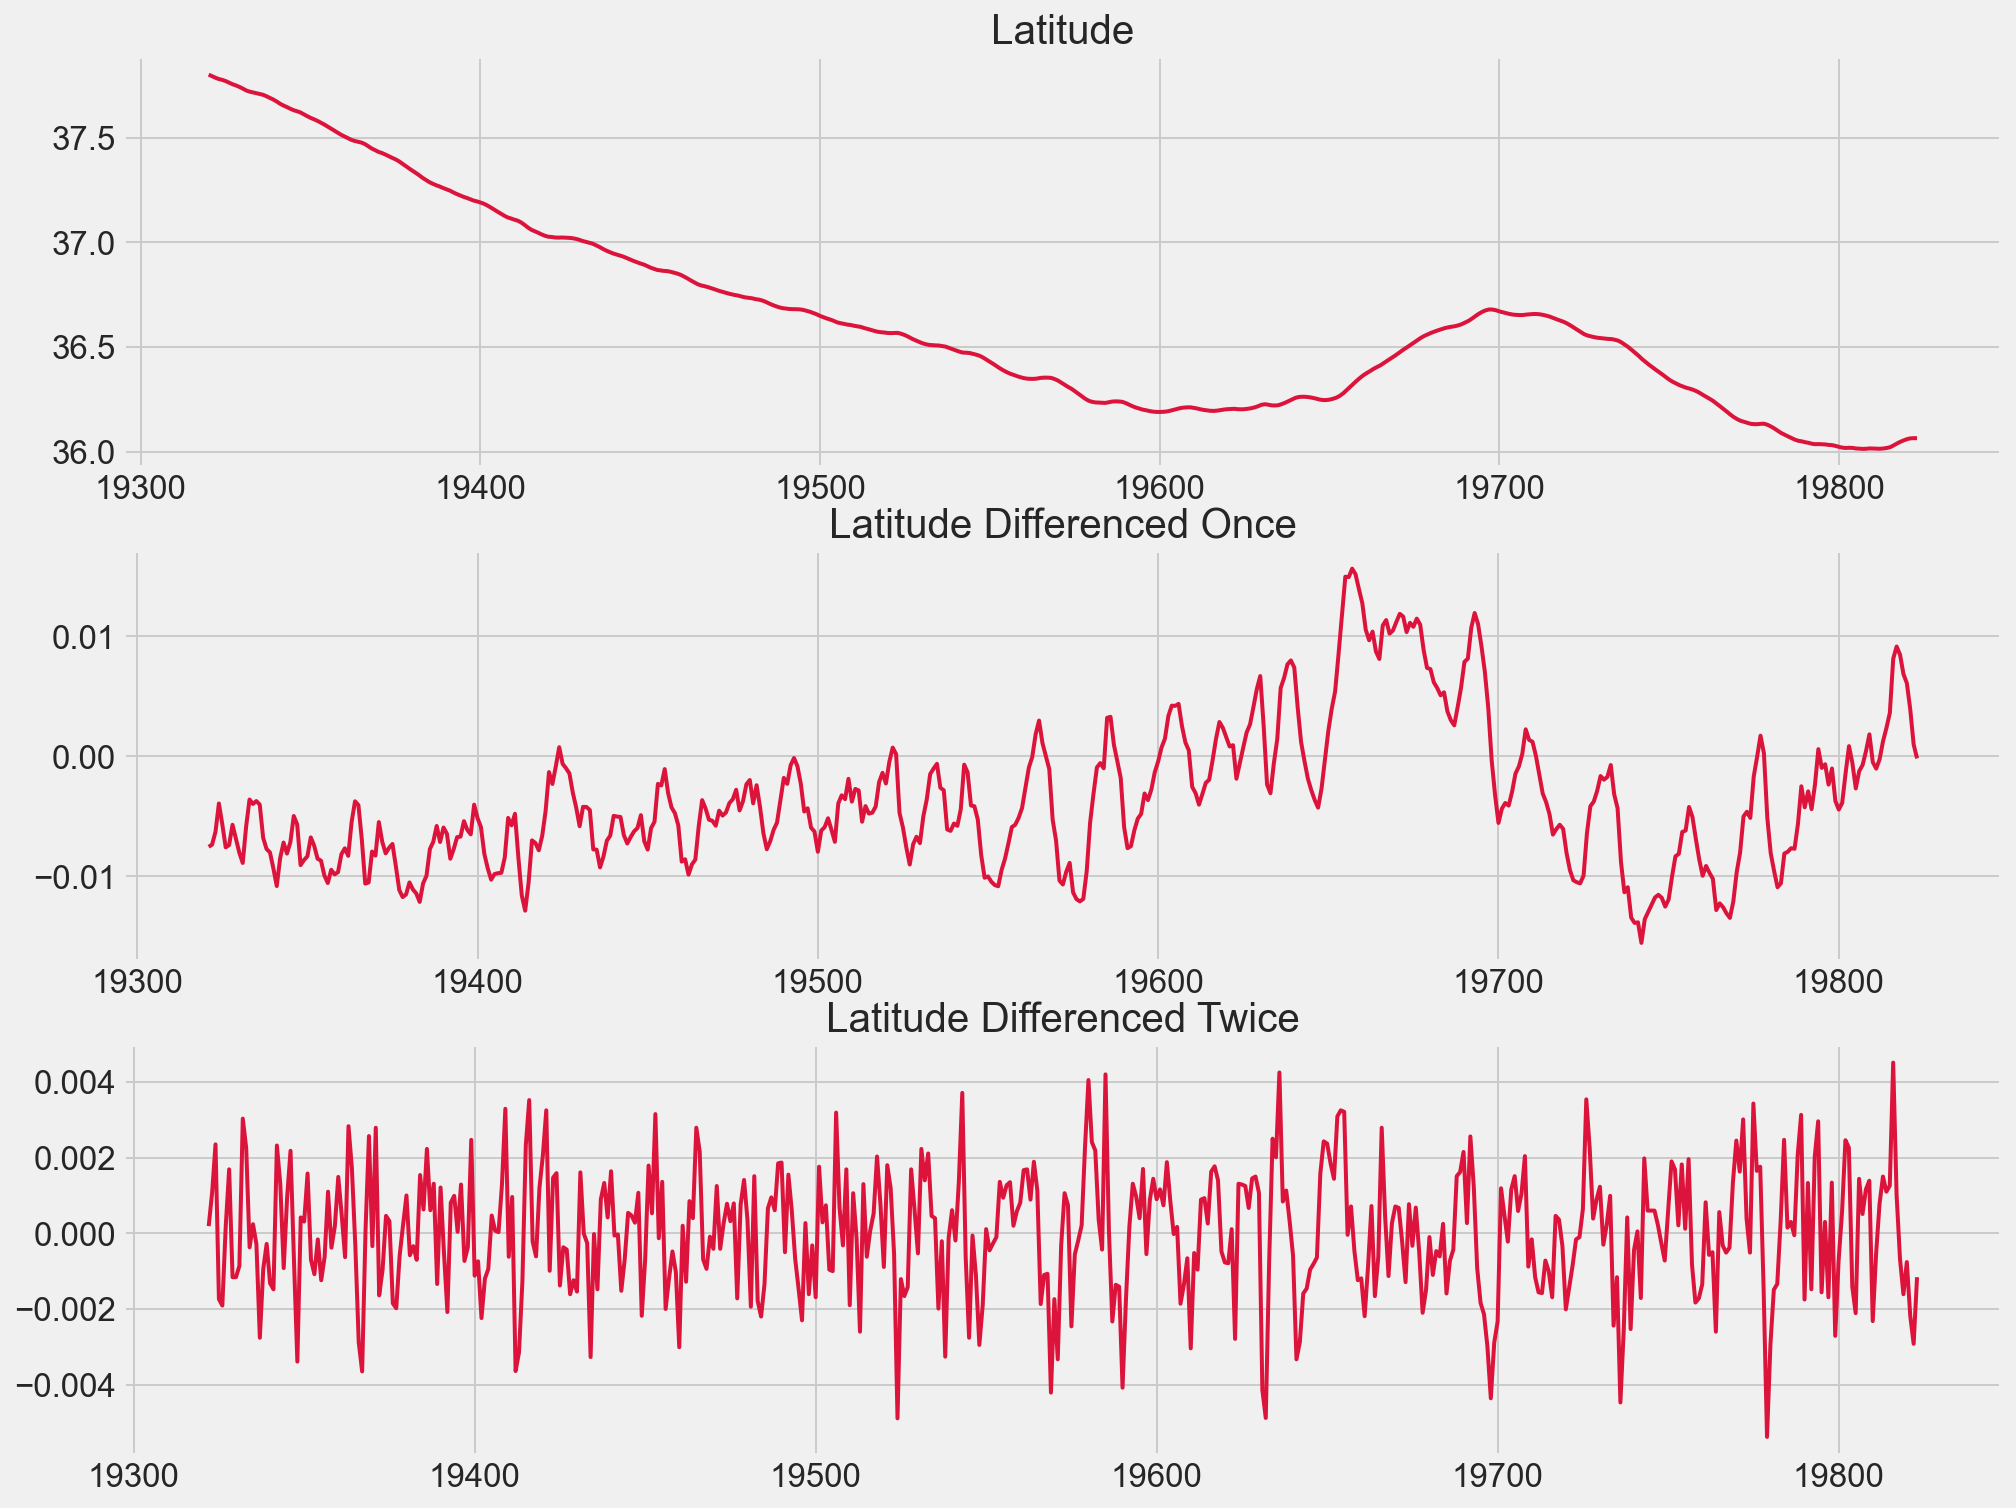

In [7]:
plot_diff(buoy_data, 35, 48, 'Latitude')

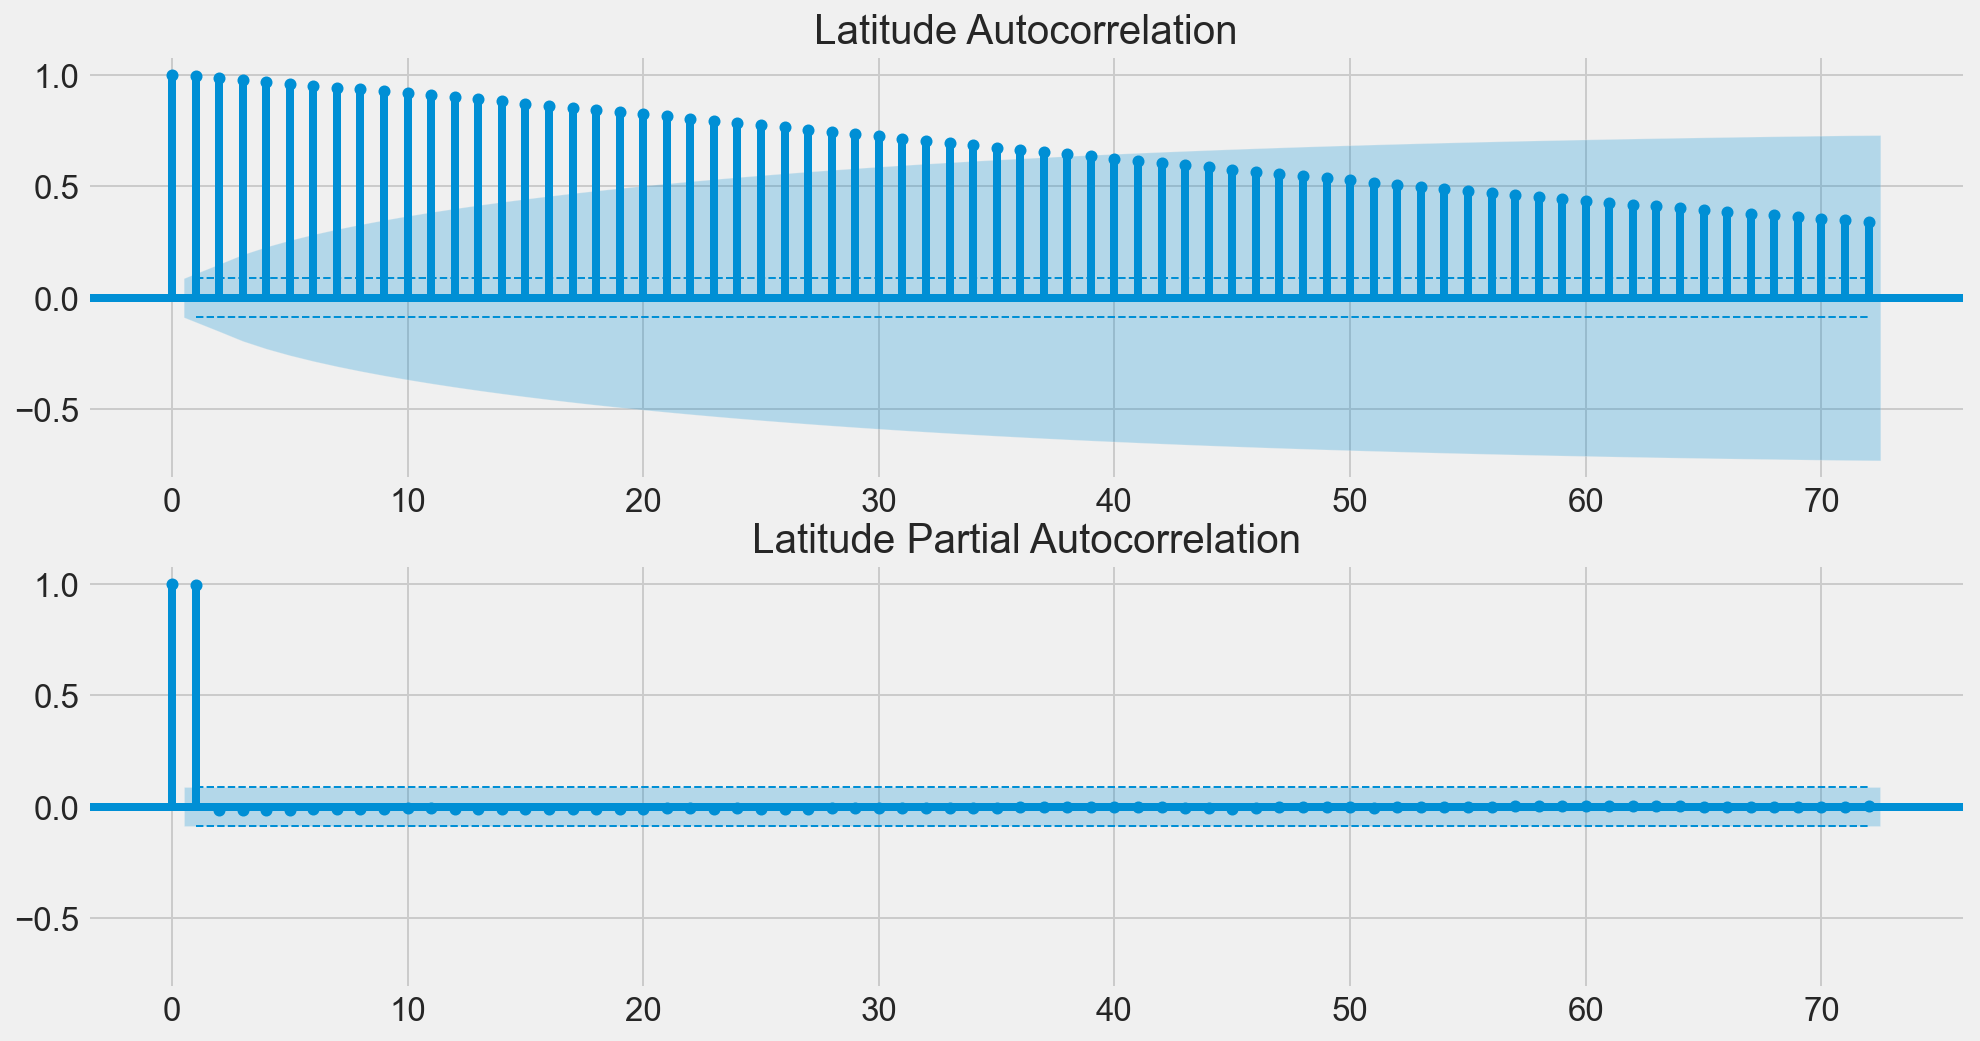

In [8]:
plot_autocorrs(buoy_data, 35, 'Latitude', 48, 72)

                               SARIMAX Results                                
Dep. Variable:               Latitude   No. Observations:                  540
Model:              SARIMAX(37, 2, 1)   Log Likelihood                2766.205
Date:                Thu, 09 Dec 2021   AIC                          -5452.409
Time:                        17:37:36   BIC                          -5280.895
Sample:                             0   HQIC                         -5385.320
                                - 540                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -7.402e-07   7.29e-05     -0.010      0.992      -0.000       0.000
ar.L1          0.1477      0.855      0.173      0.863      -1.528       1.824
ar.L2          0.0763      0.237      0.322      0.7

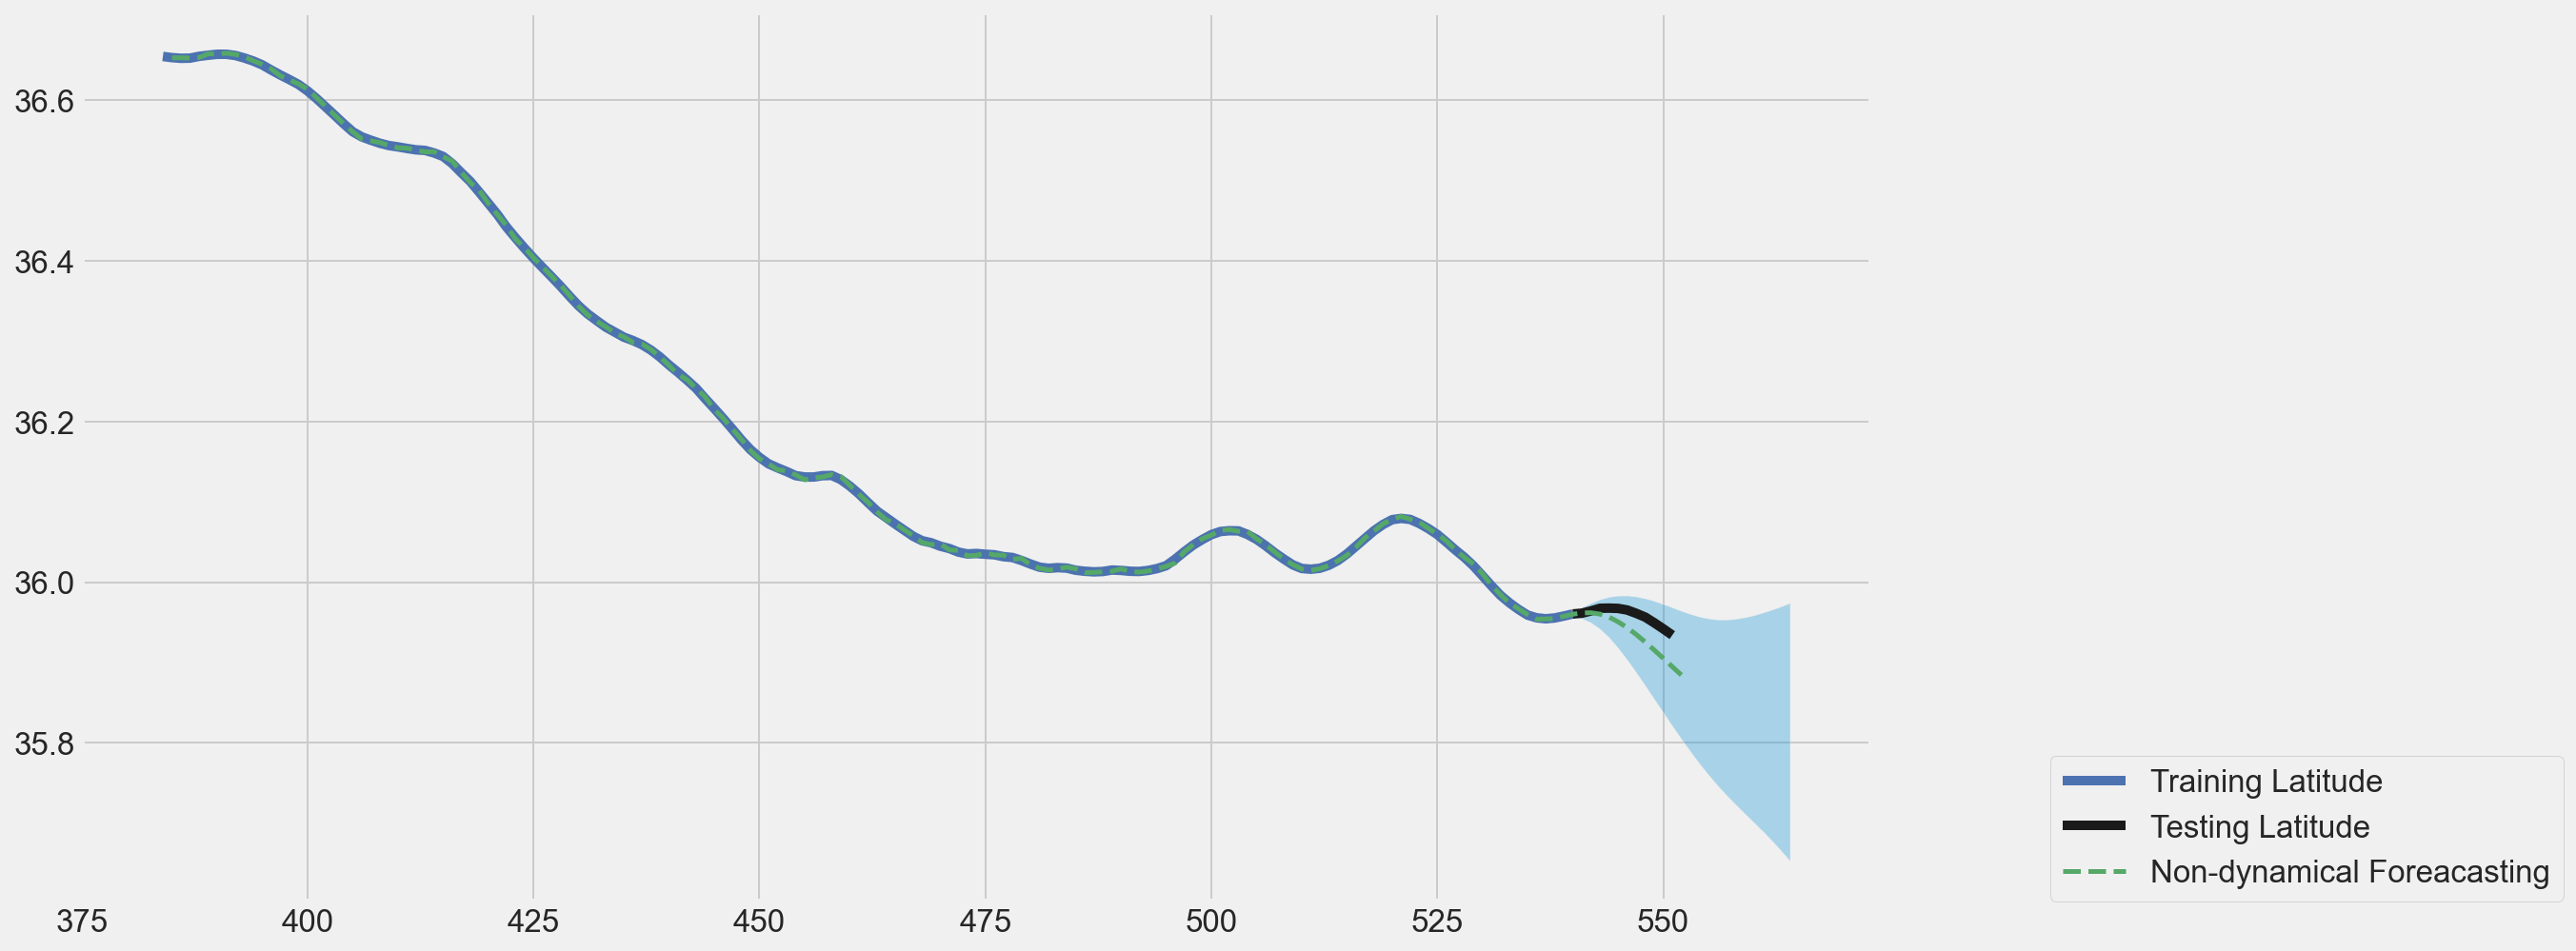

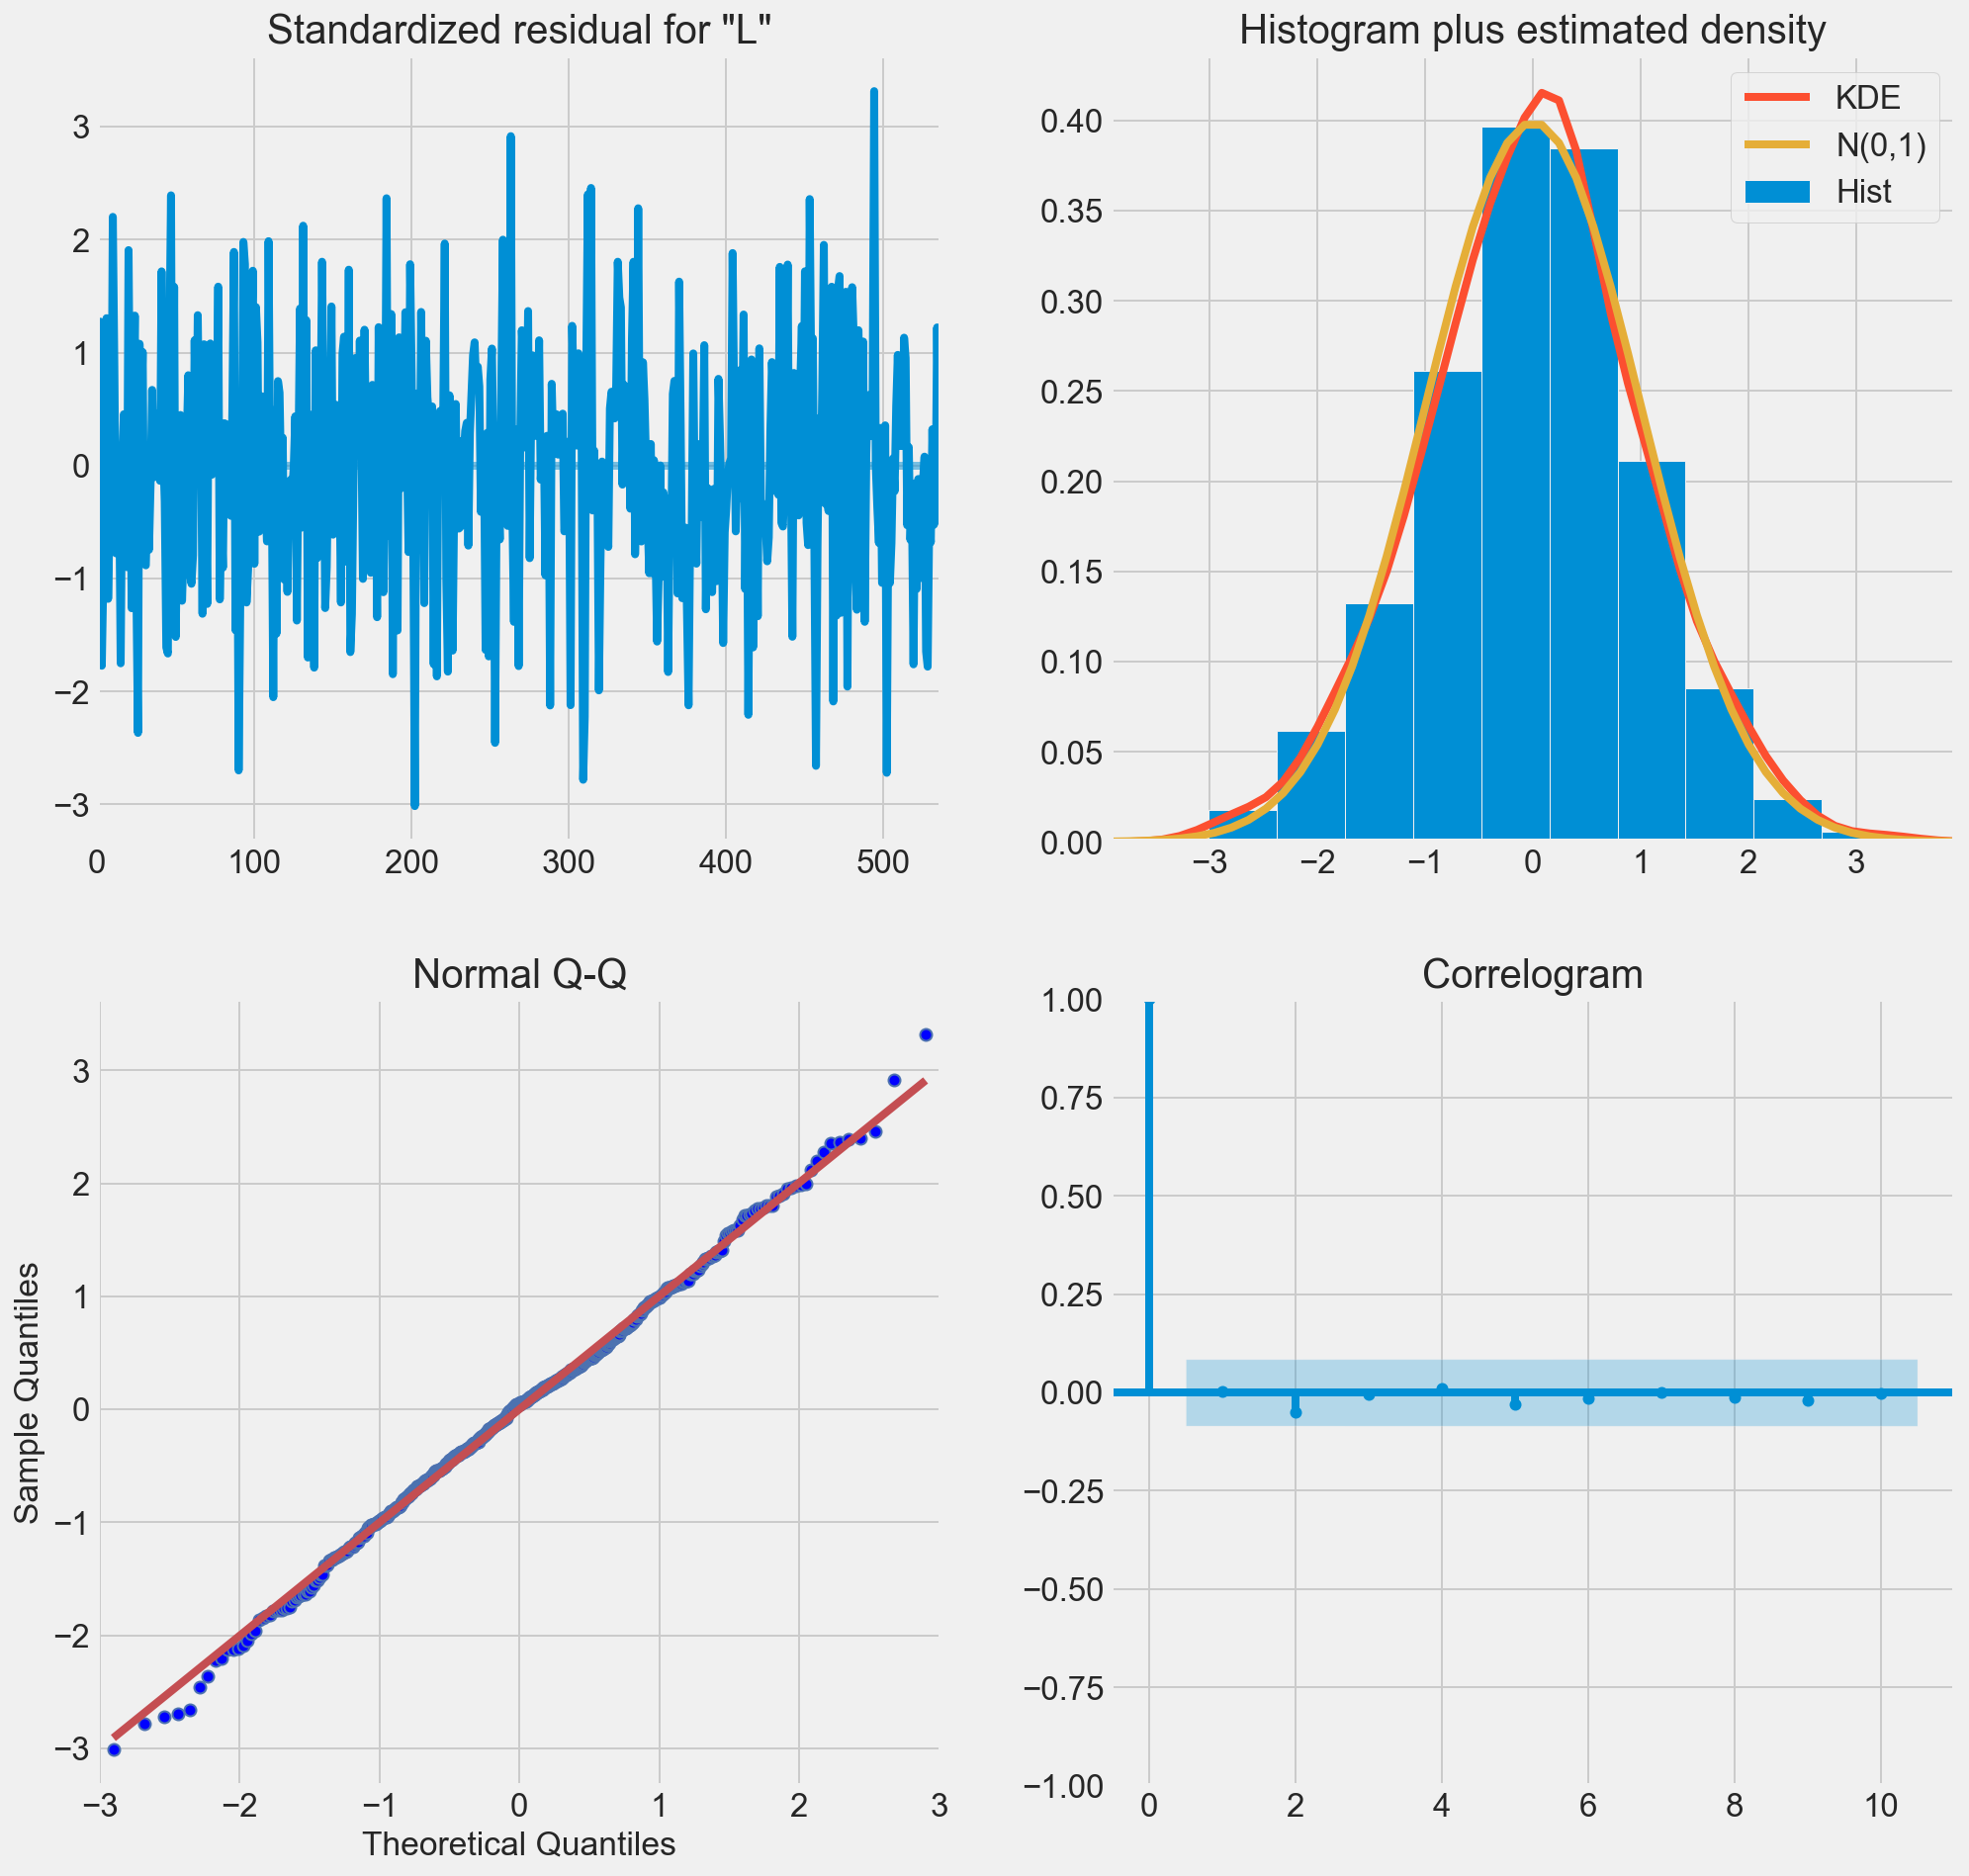

In [9]:
make_predict(data=buoy_data, buoy_id=35, feature='Latitude', order=(37, 2, 1),
                     start_p=24, end_p=12, exog_features=[])

                               SARIMAX Results                                
Dep. Variable:               Latitude   No. Observations:                  540
Model:              SARIMAX(37, 2, 1)   Log Likelihood                2766.527
Date:                Thu, 09 Dec 2021   AIC                          -5447.054
Time:                        17:37:48   BIC                          -5262.677
Sample:                             0   HQIC                         -5374.933
                                - 540                                         
Covariance Type:                  opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
intercept                3.831e-06   7.39e-05      0.052      0.959      -0.000       0.000
Significant Wave Height     0.0004      0.000      1.250      0.211      -0.000       0.001


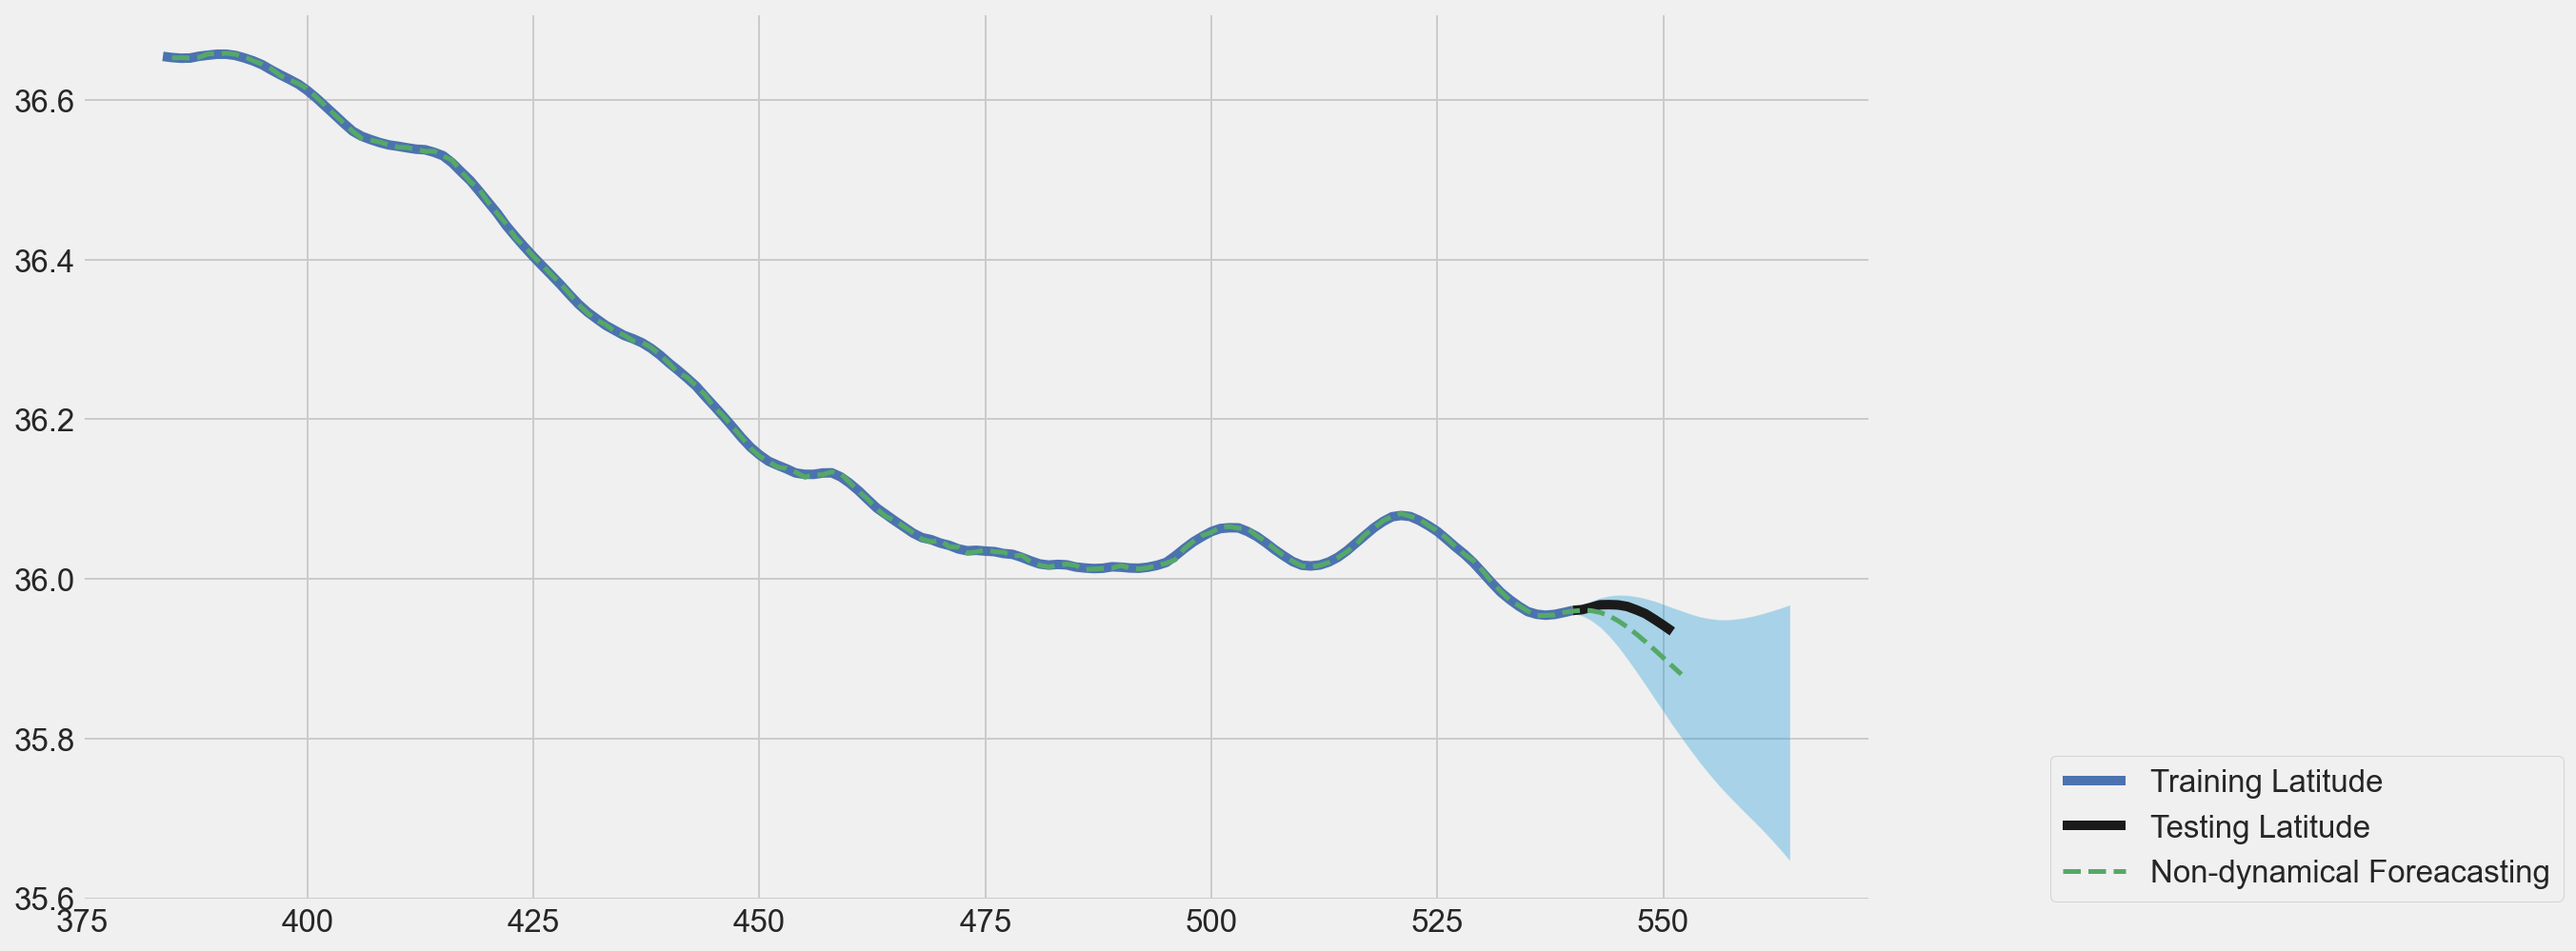

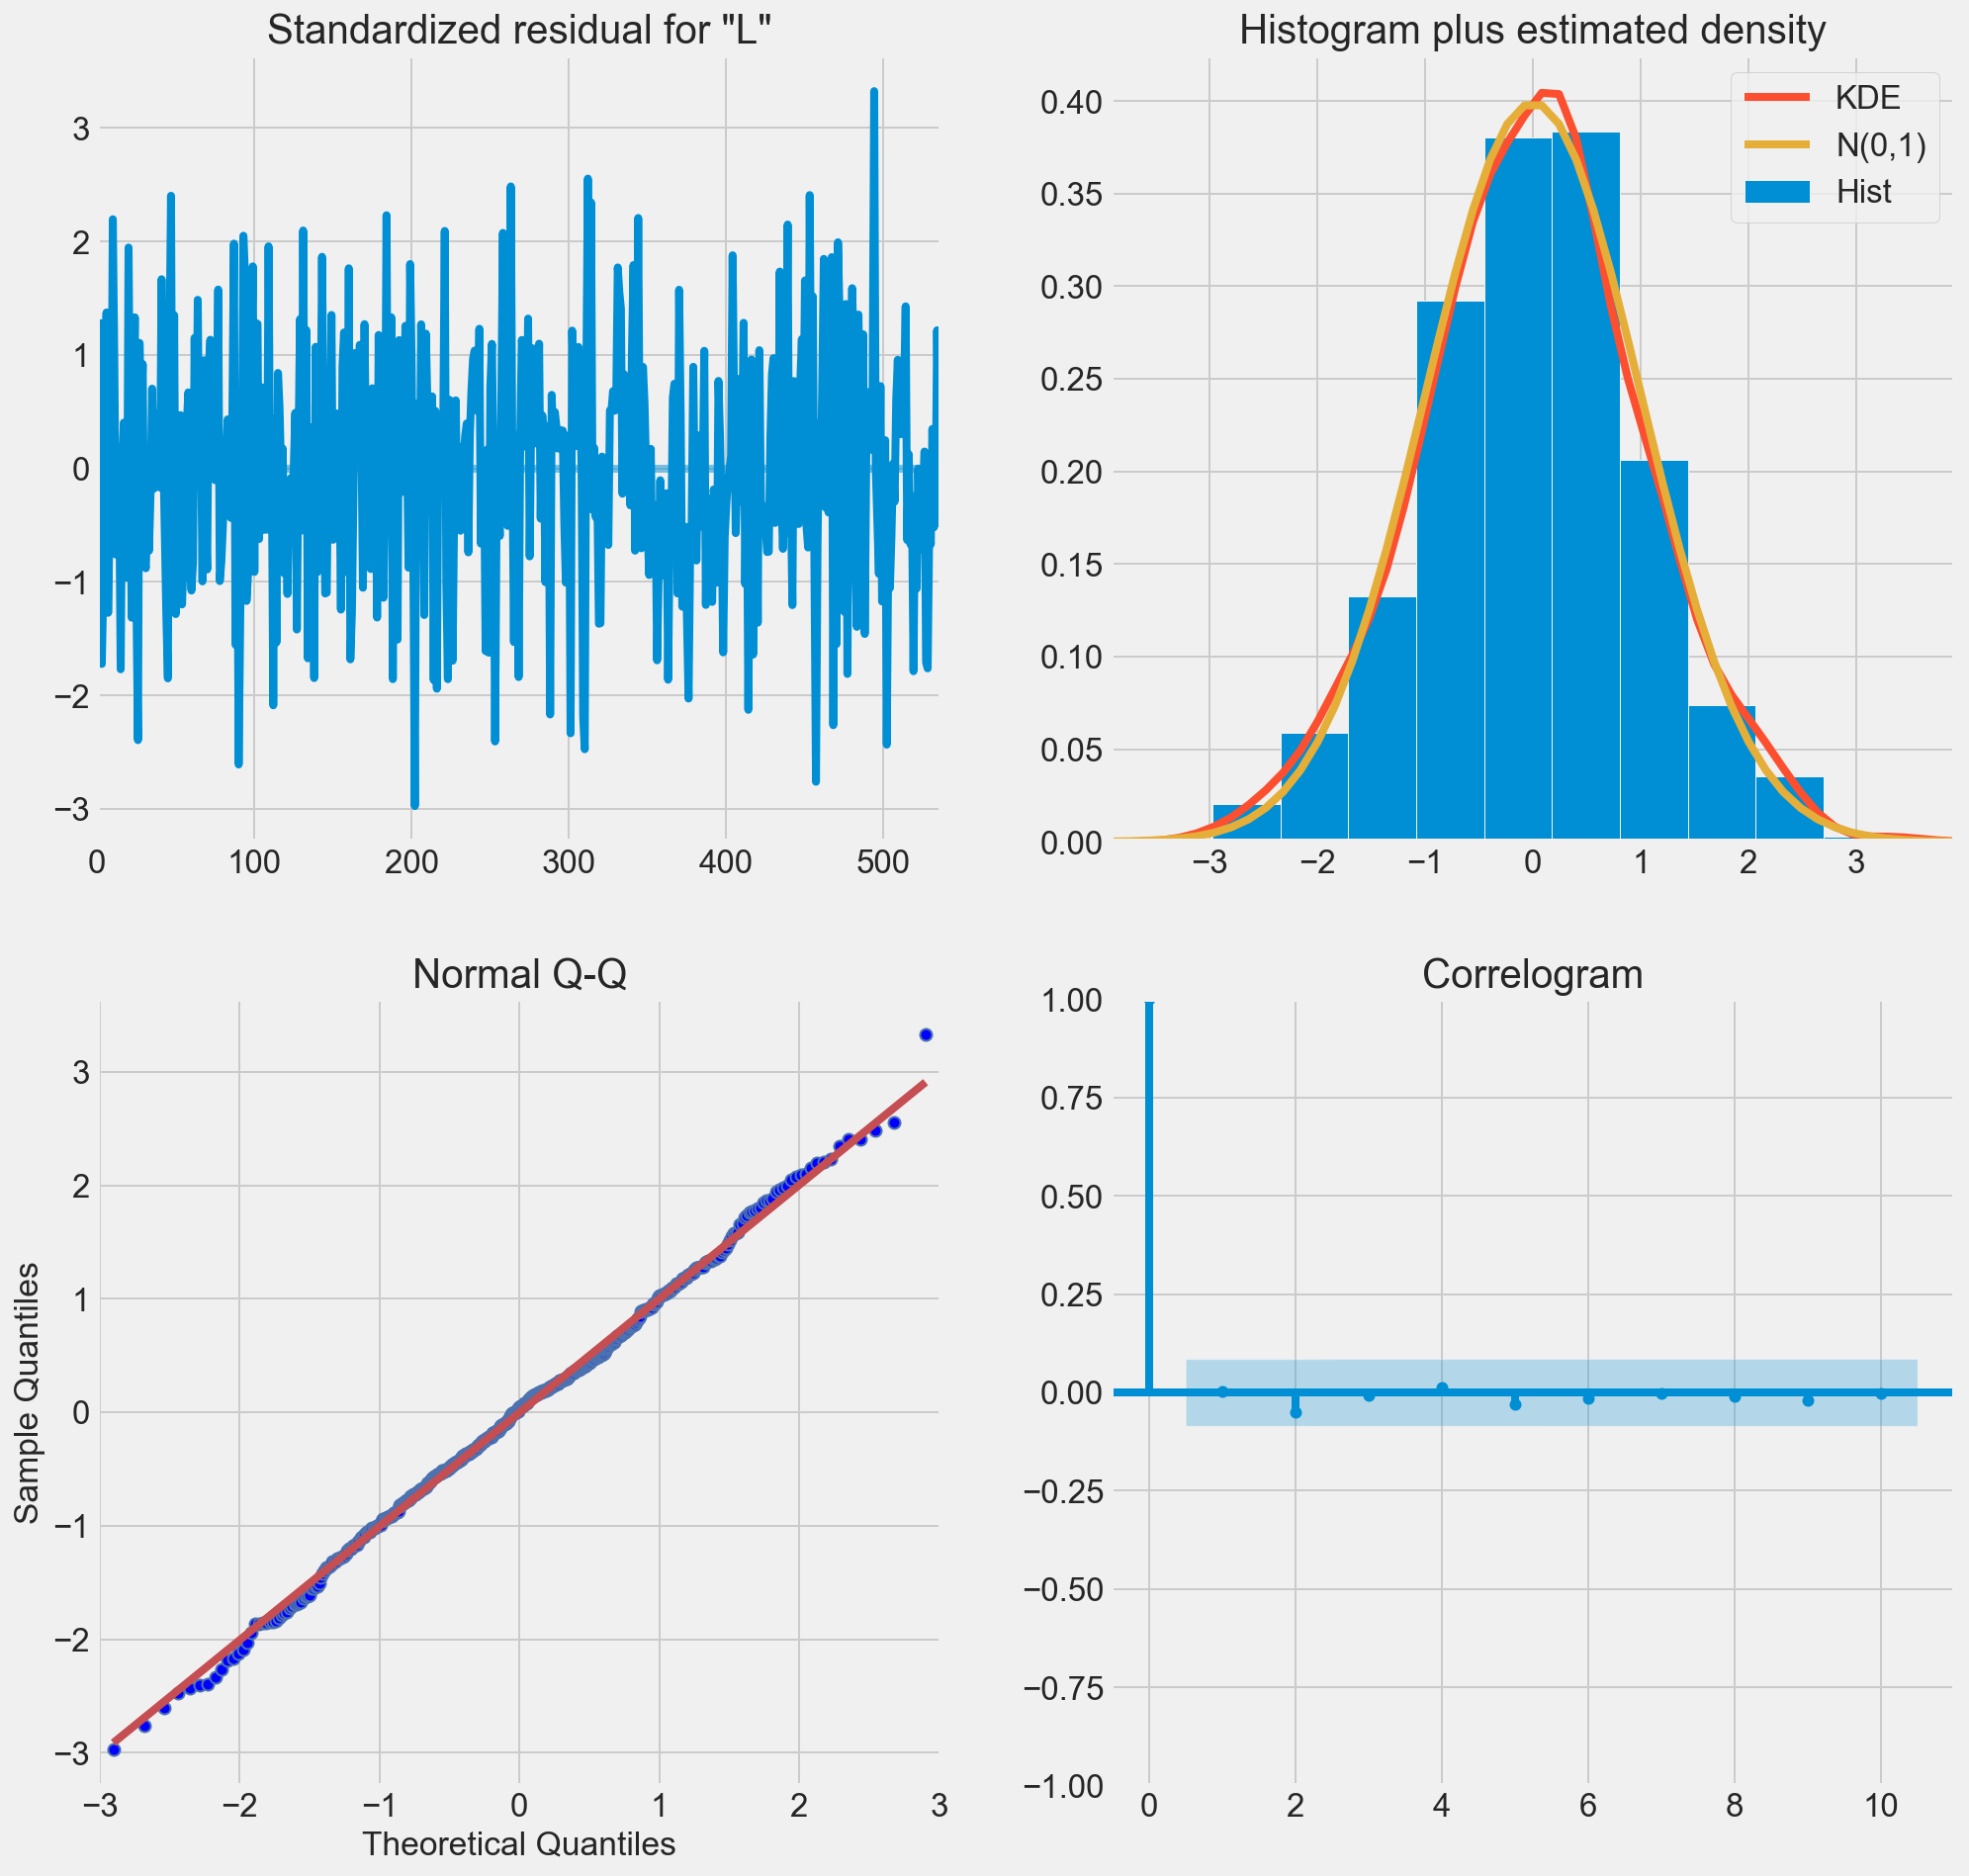

In [10]:
make_predict(data=buoy_data, buoy_id=35, feature='Latitude', order=(37, 2, 1),
              start_p=24, end_p=12, exog_features=['Significant Wave Height', 'Peak Direction', 'Current Direction'])

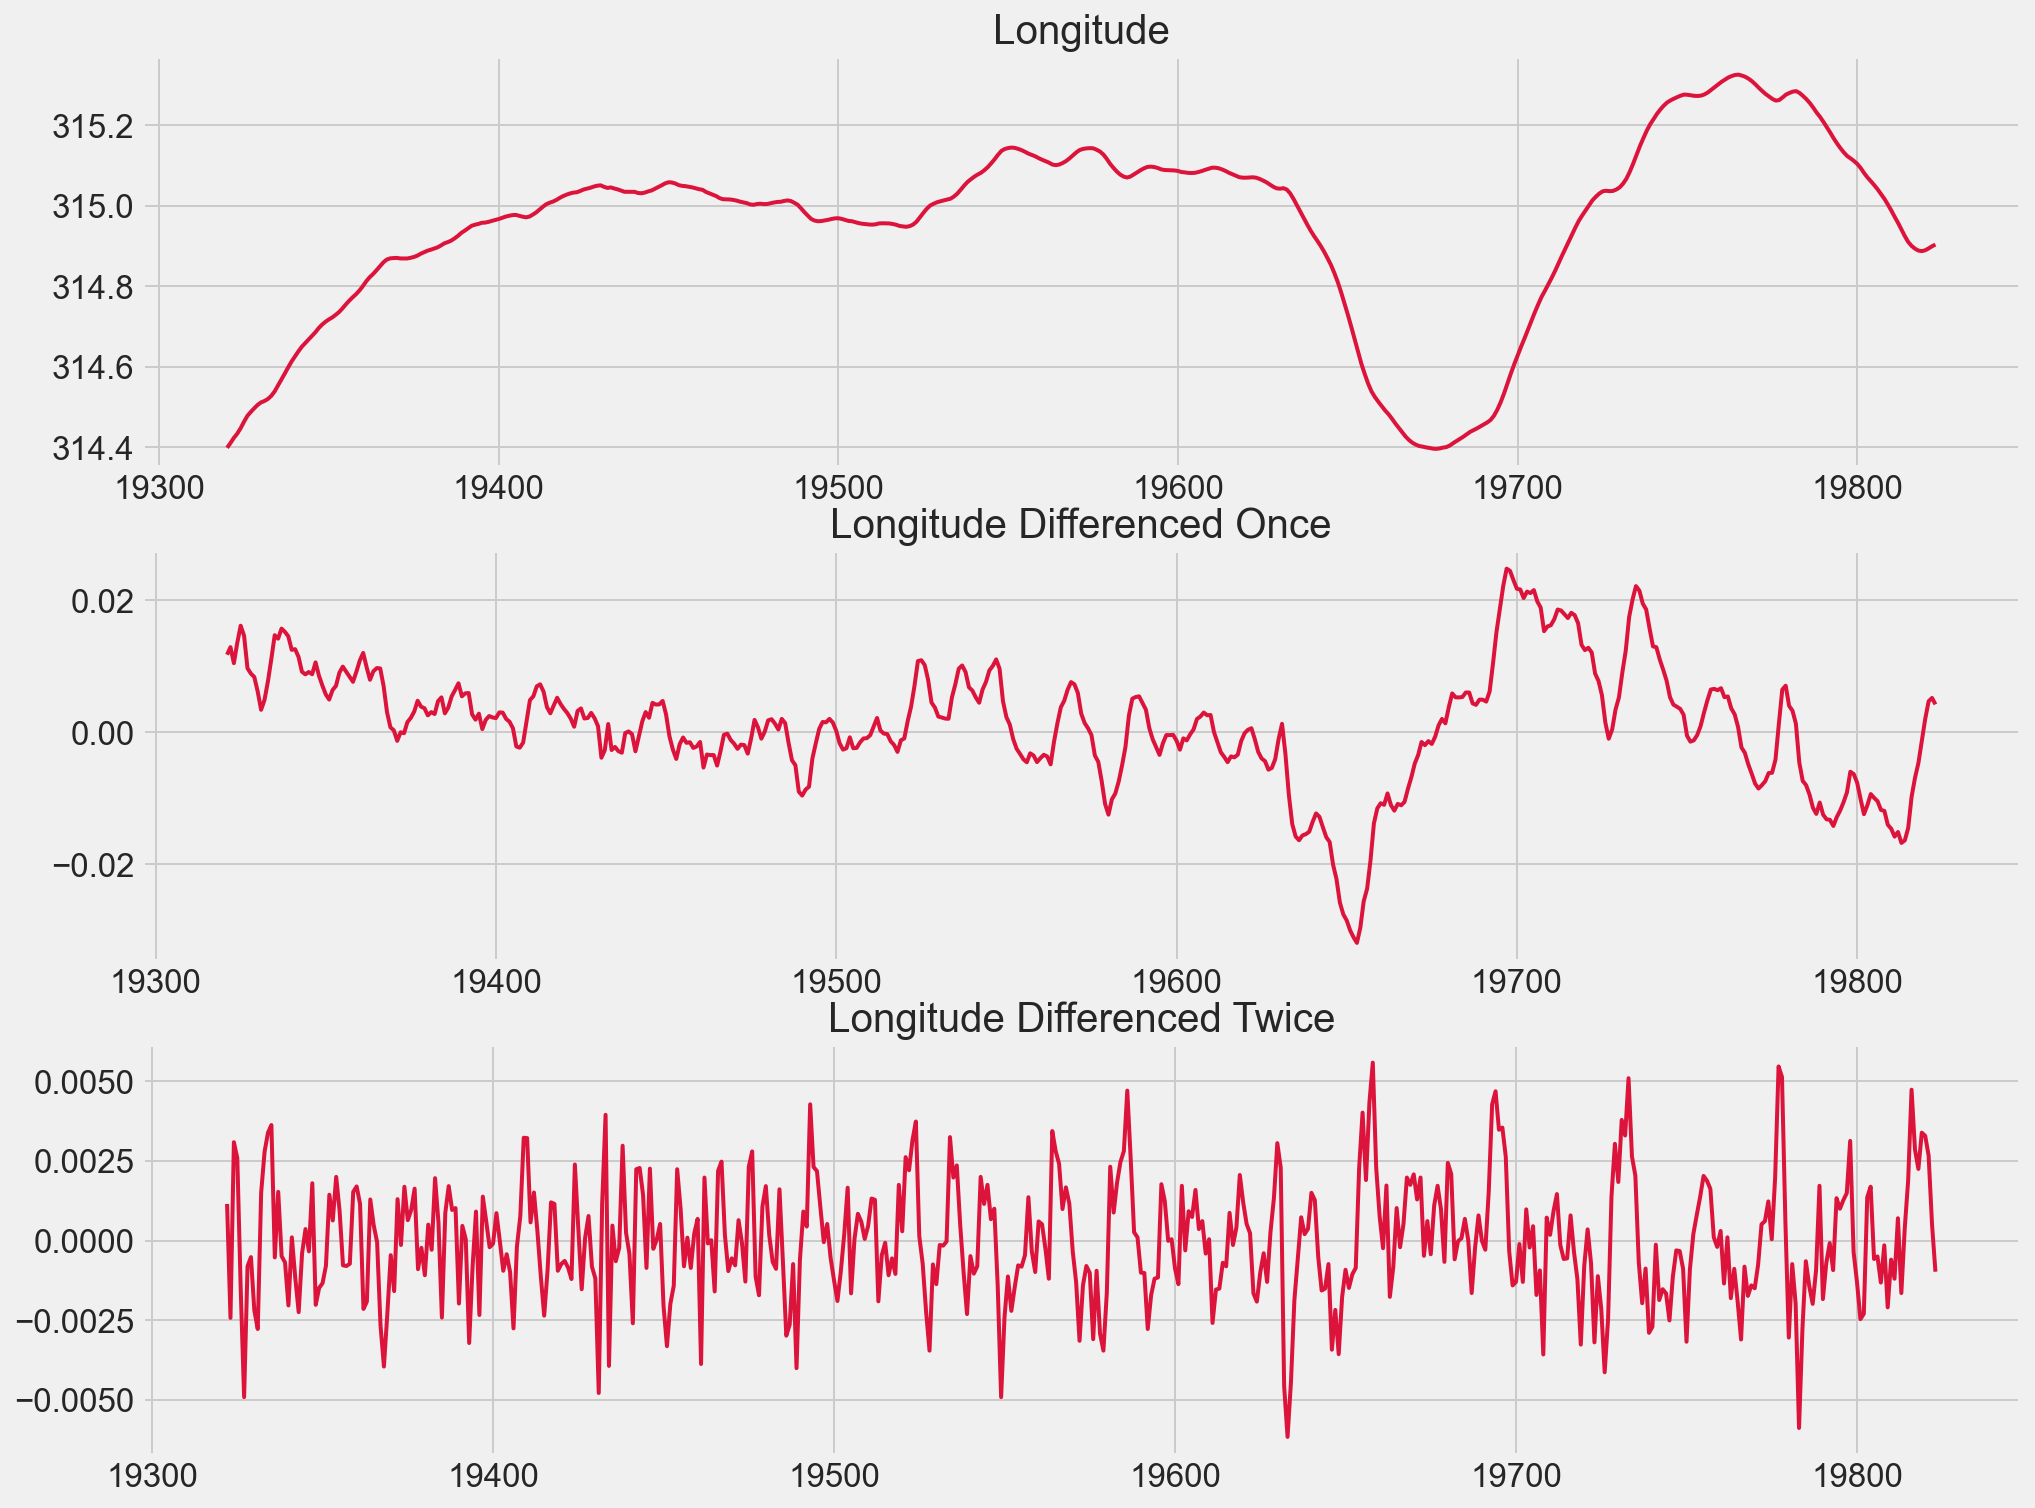

In [11]:
plot_diff(buoy_data, 35, 48, 'Longitude')

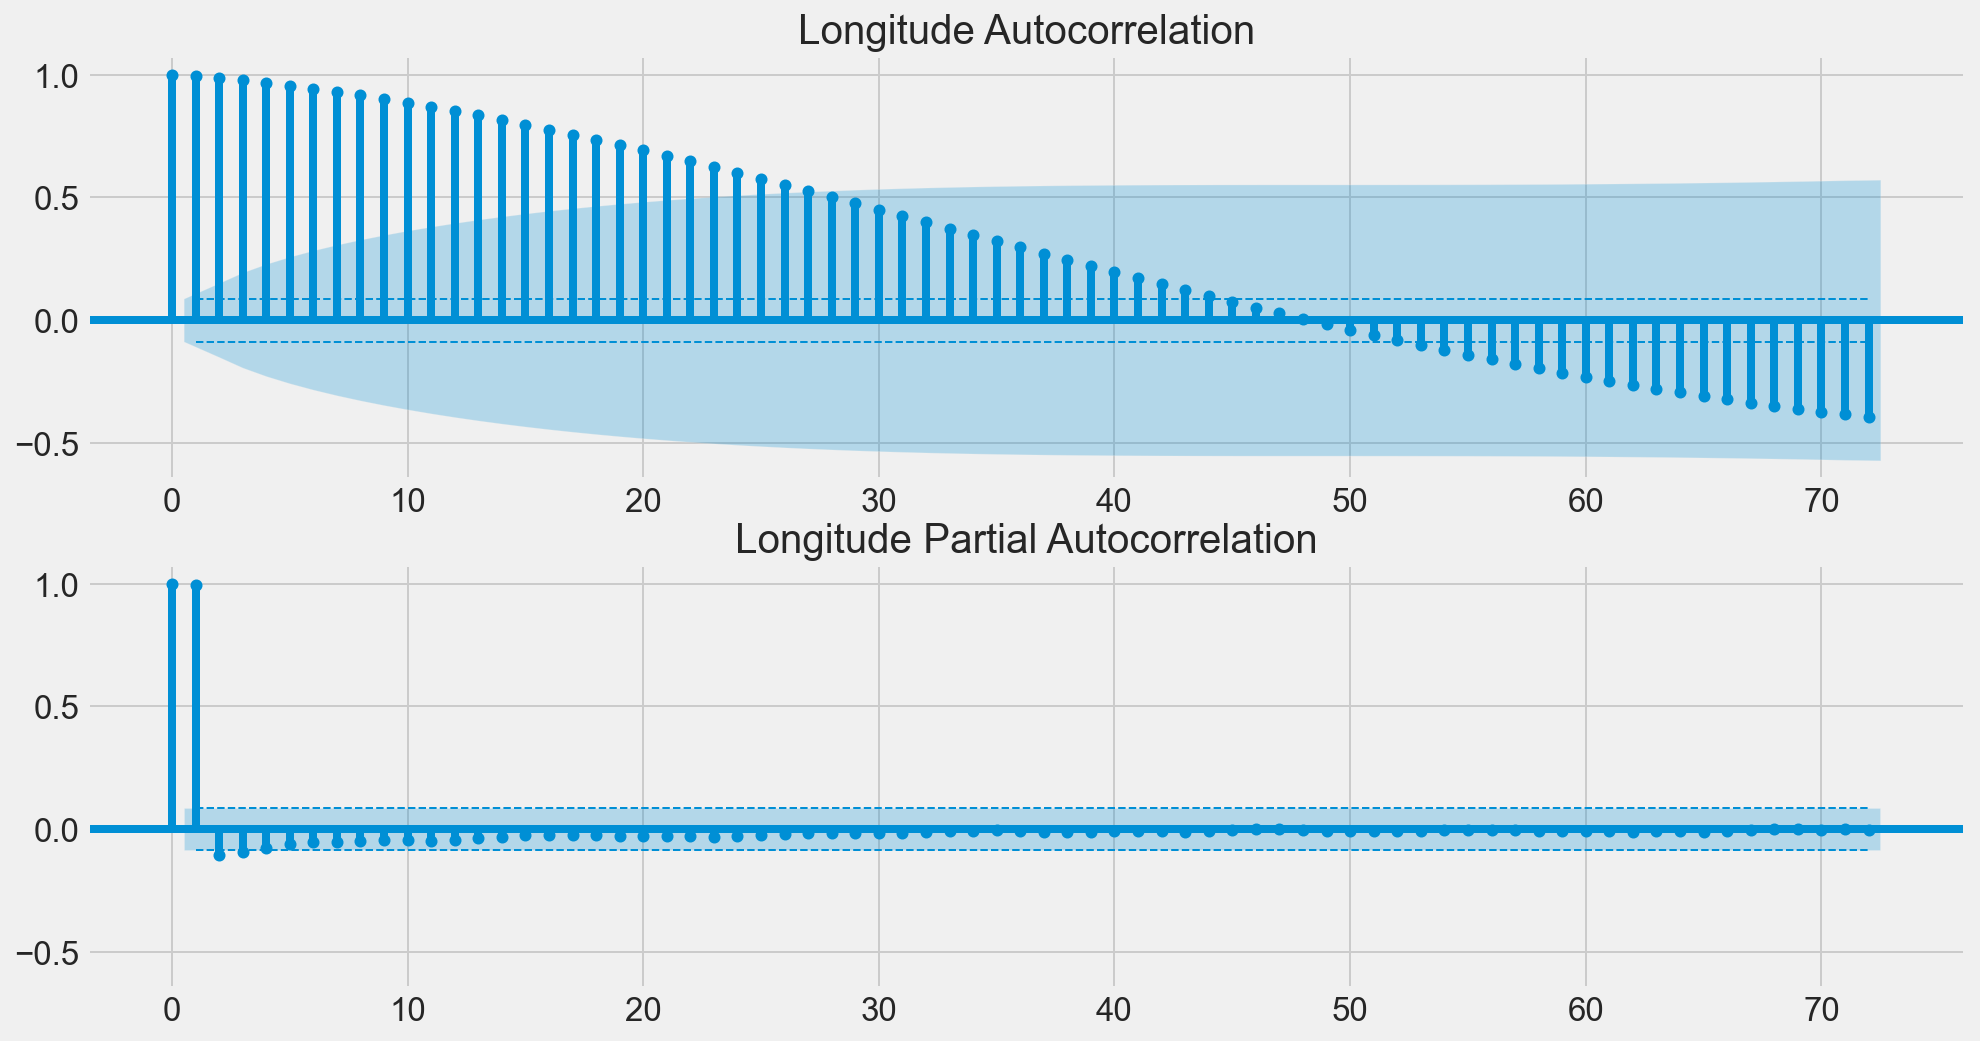

In [12]:
plot_autocorrs(buoy_data, 35, 'Longitude', 48, 72)

                               SARIMAX Results                                
Dep. Variable:              Longitude   No. Observations:                  540
Model:              SARIMAX(26, 2, 4)   Log Likelihood                2720.443
Date:                Thu, 09 Dec 2021   AIC                          -5376.887
Time:                        17:37:53   BIC                          -5239.675
Sample:                             0   HQIC                         -5323.215
                                - 540                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.783e-05    9.3e-05     -0.192      0.848      -0.000       0.000
ar.L1          0.2599      0.746      0.348      0.727      -1.202       1.722
ar.L2          0.0562      0.763      0.074      0.9

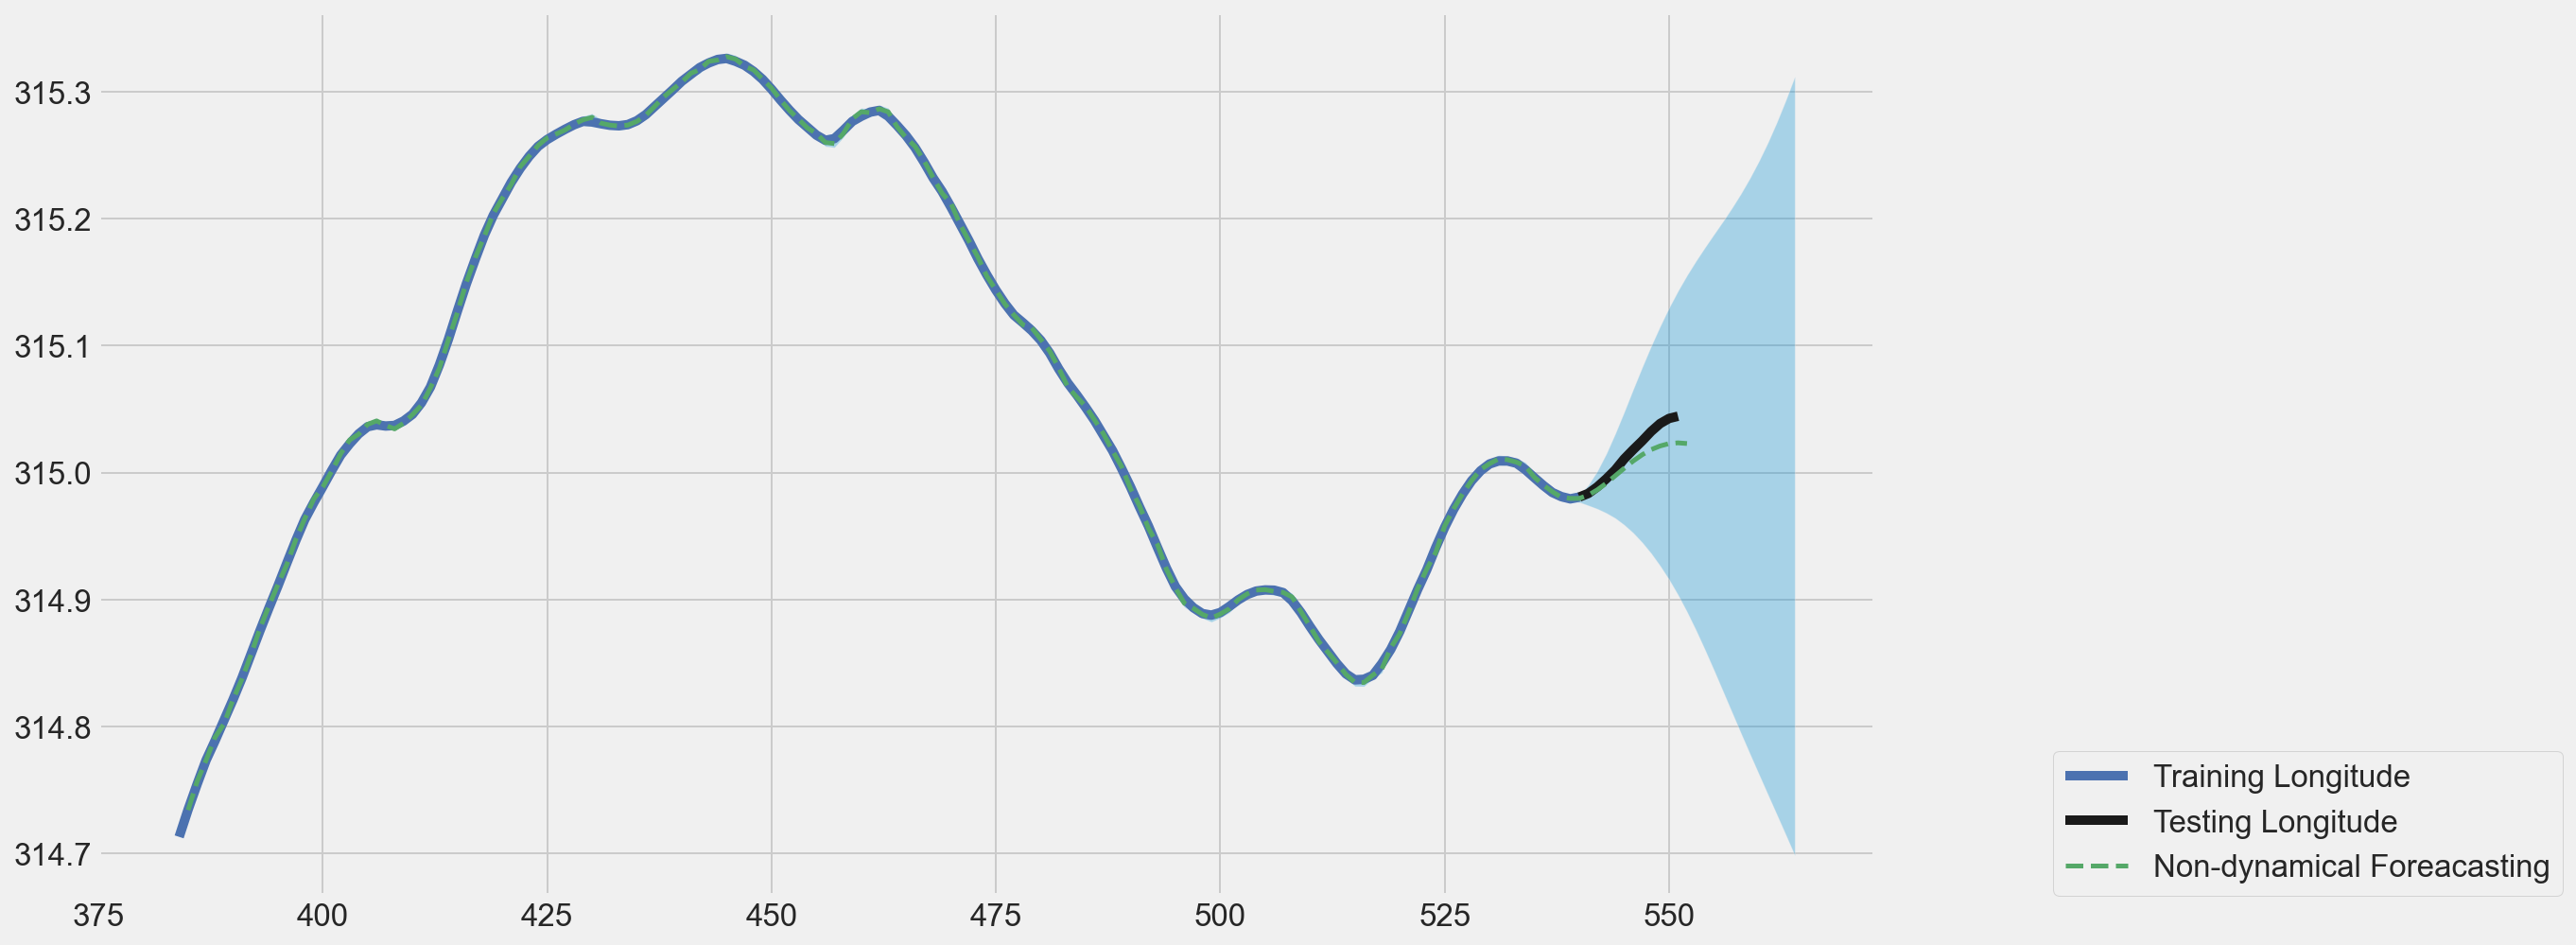

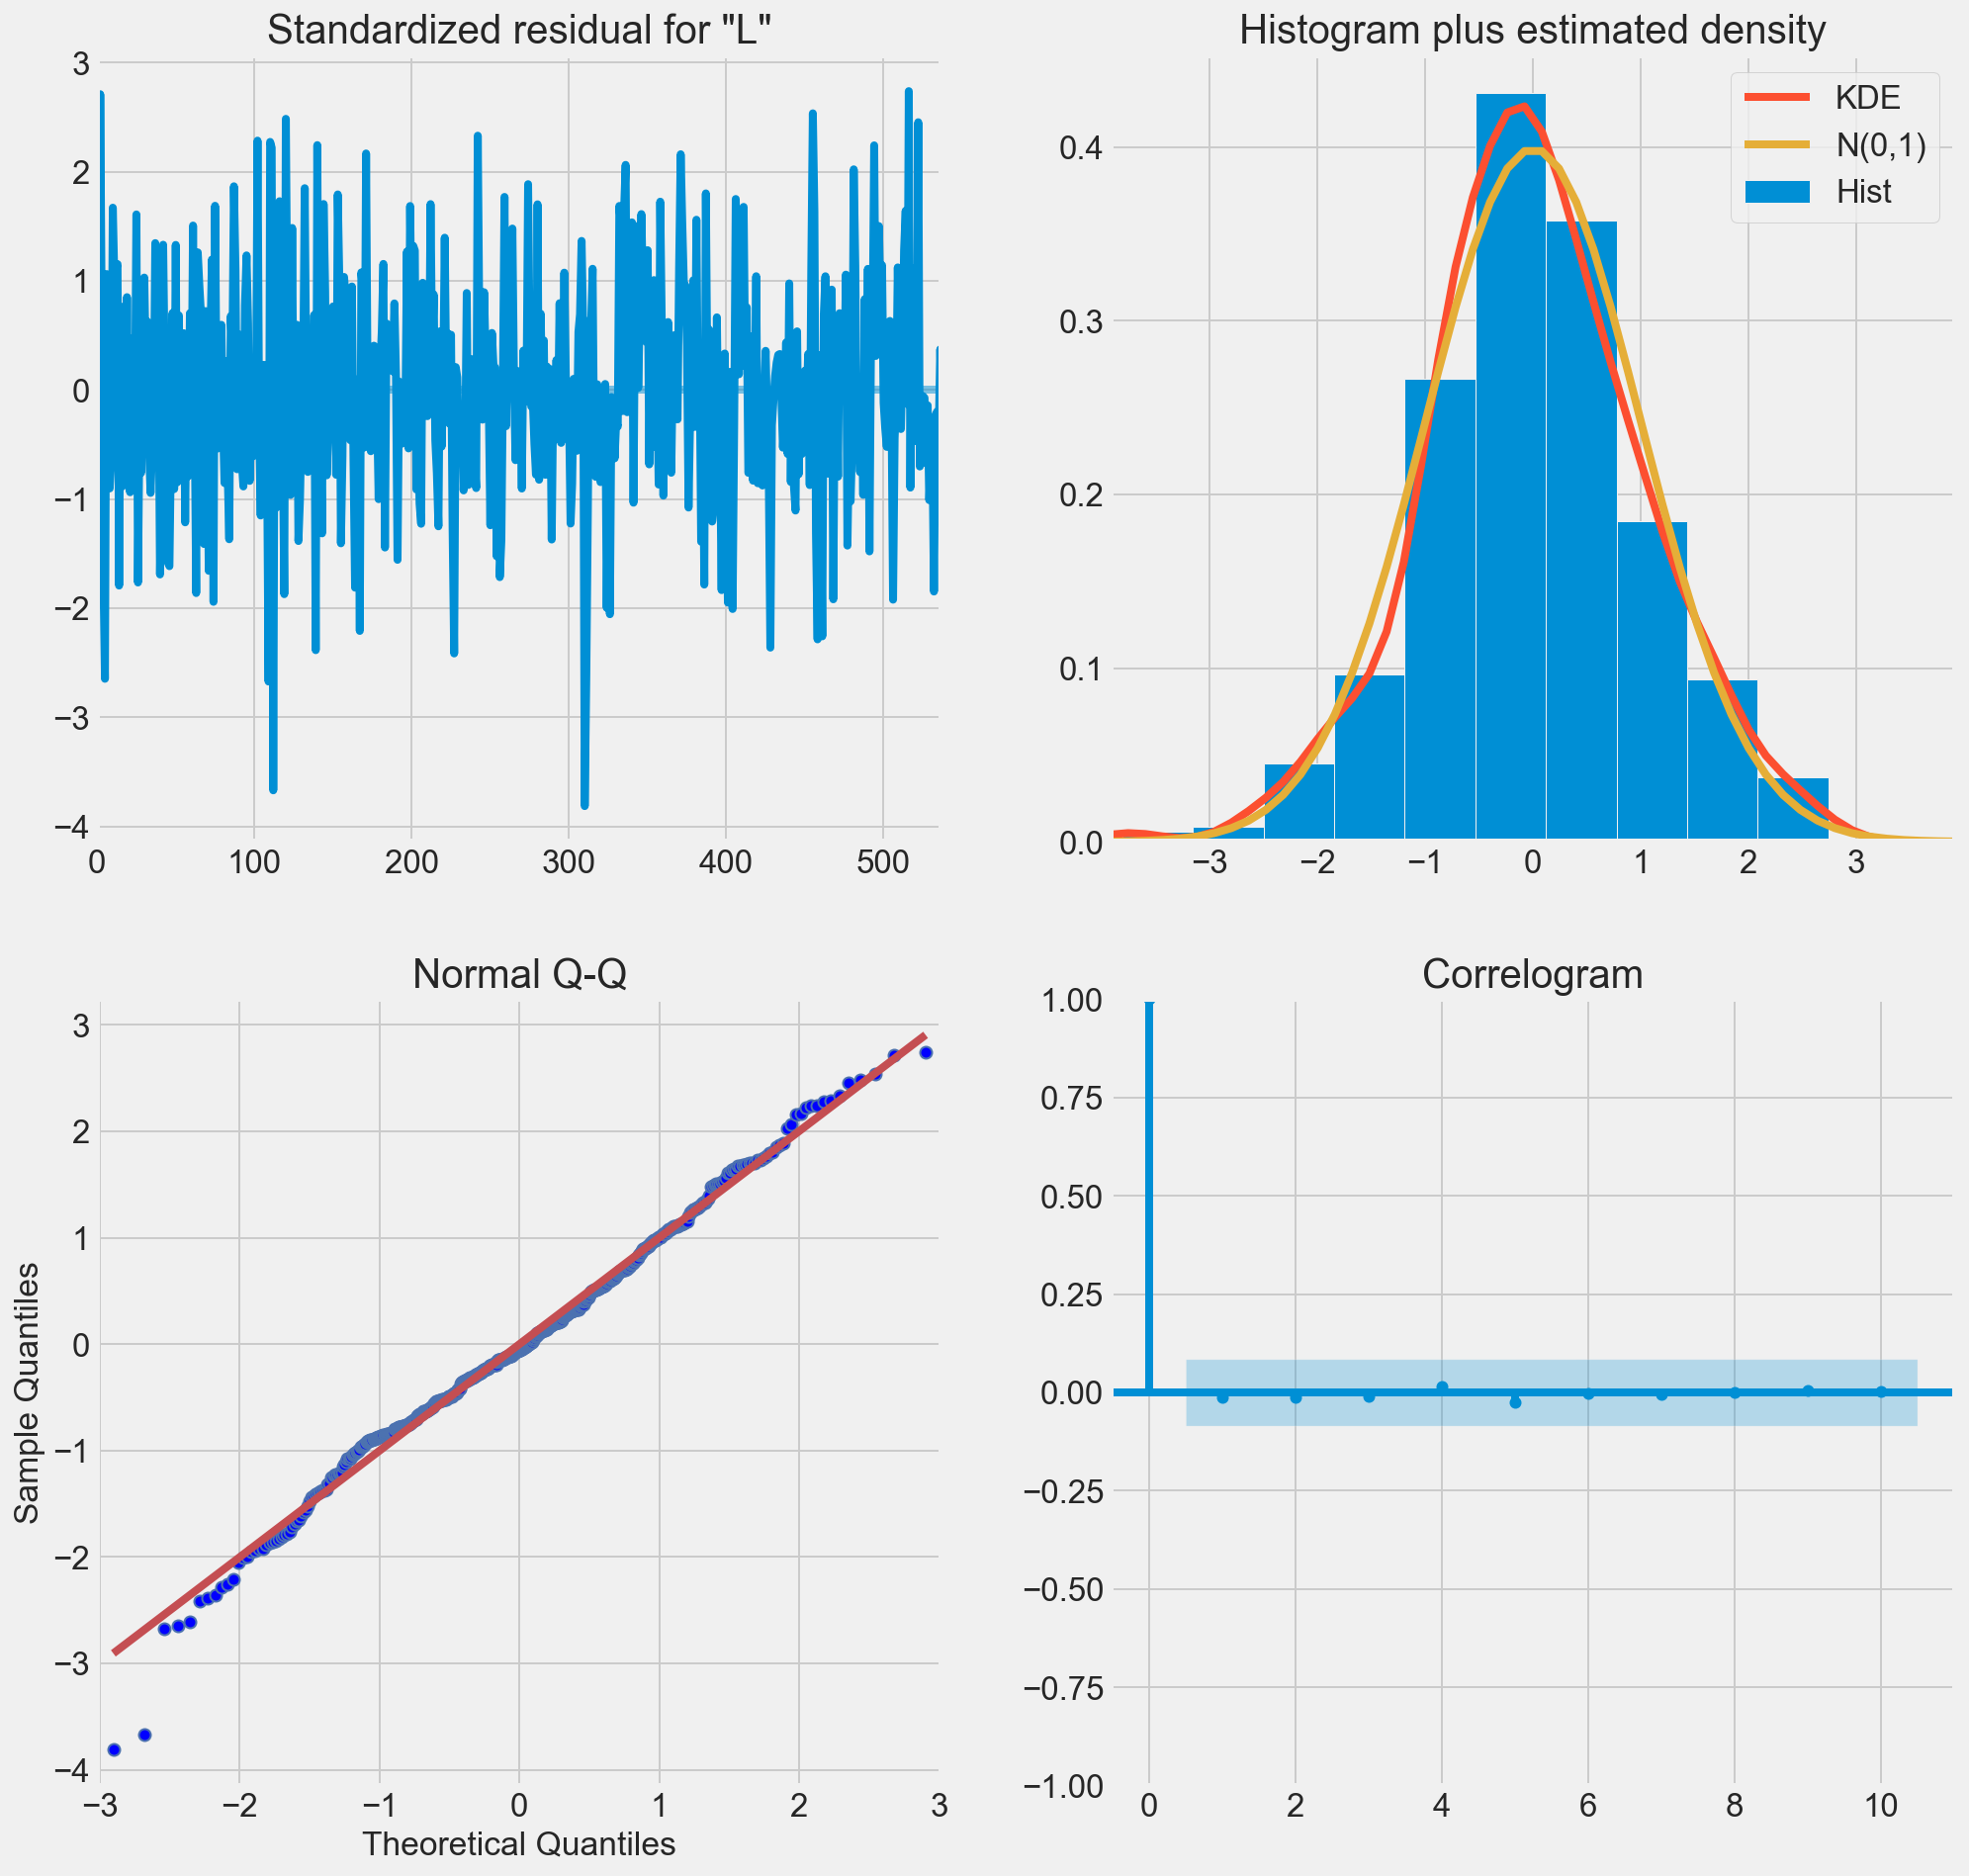

In [13]:
make_predict(data=buoy_data, buoy_id=35, feature='Longitude', order=(26, 2, 4),
                     start_p=24, end_p=12, exog_features=[])

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:              Longitude   No. Observations:                  540
Model:              SARIMAX(36, 2, 4)   Log Likelihood                2726.990
Date:                Thu, 09 Dec 2021   AIC                          -5363.980
Time:                        17:38:03   BIC                          -5171.027
Sample:                             0   HQIC                         -5288.504
                                - 540                                         
Covariance Type:                  opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
intercept               -1.027e-05   9.15e-05     -0.112      0.911      -0.000       0.000
Significant Wave Height    -0.0003      0.000     -0.756      0.450      -0.001       0.000


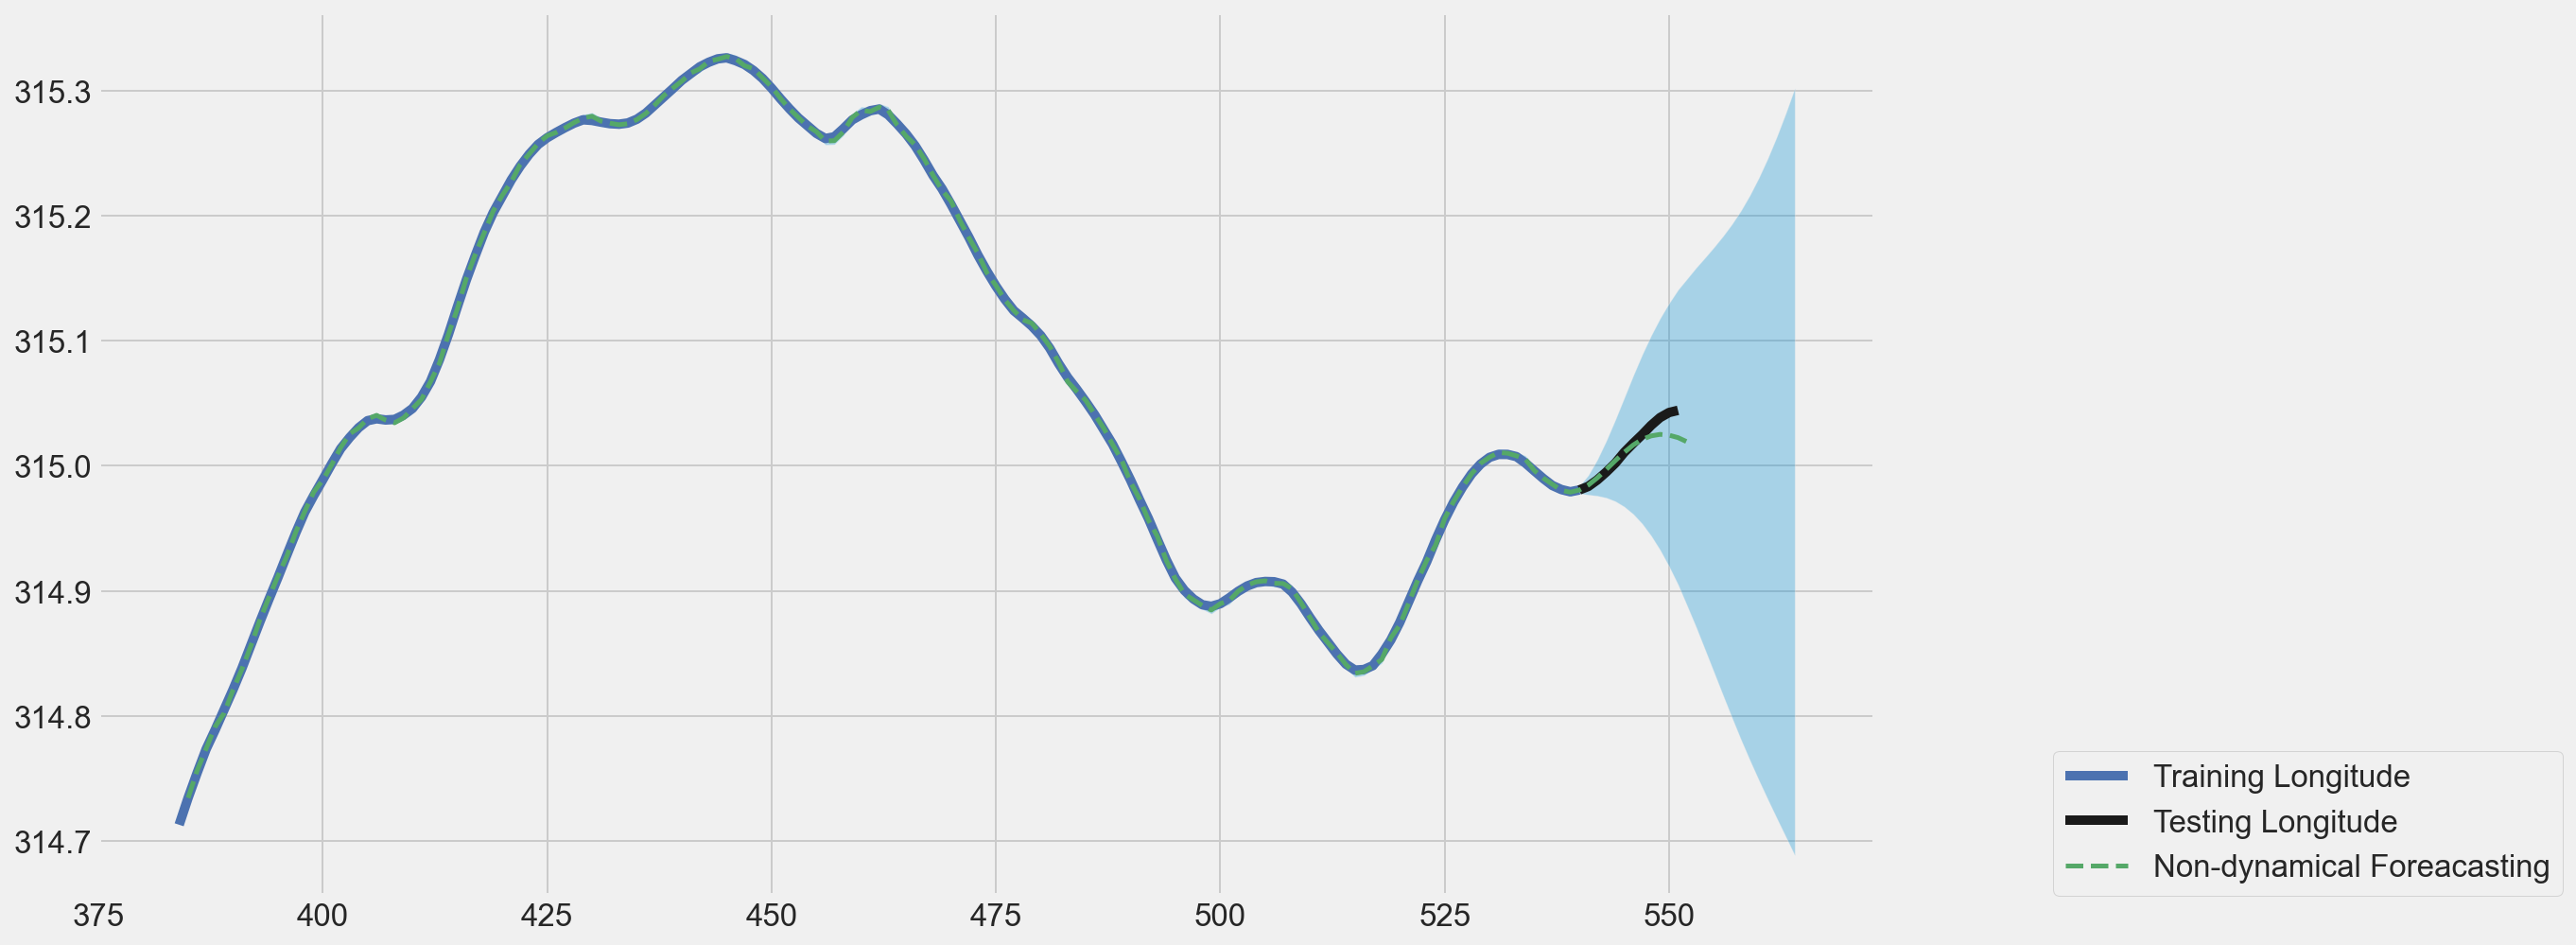

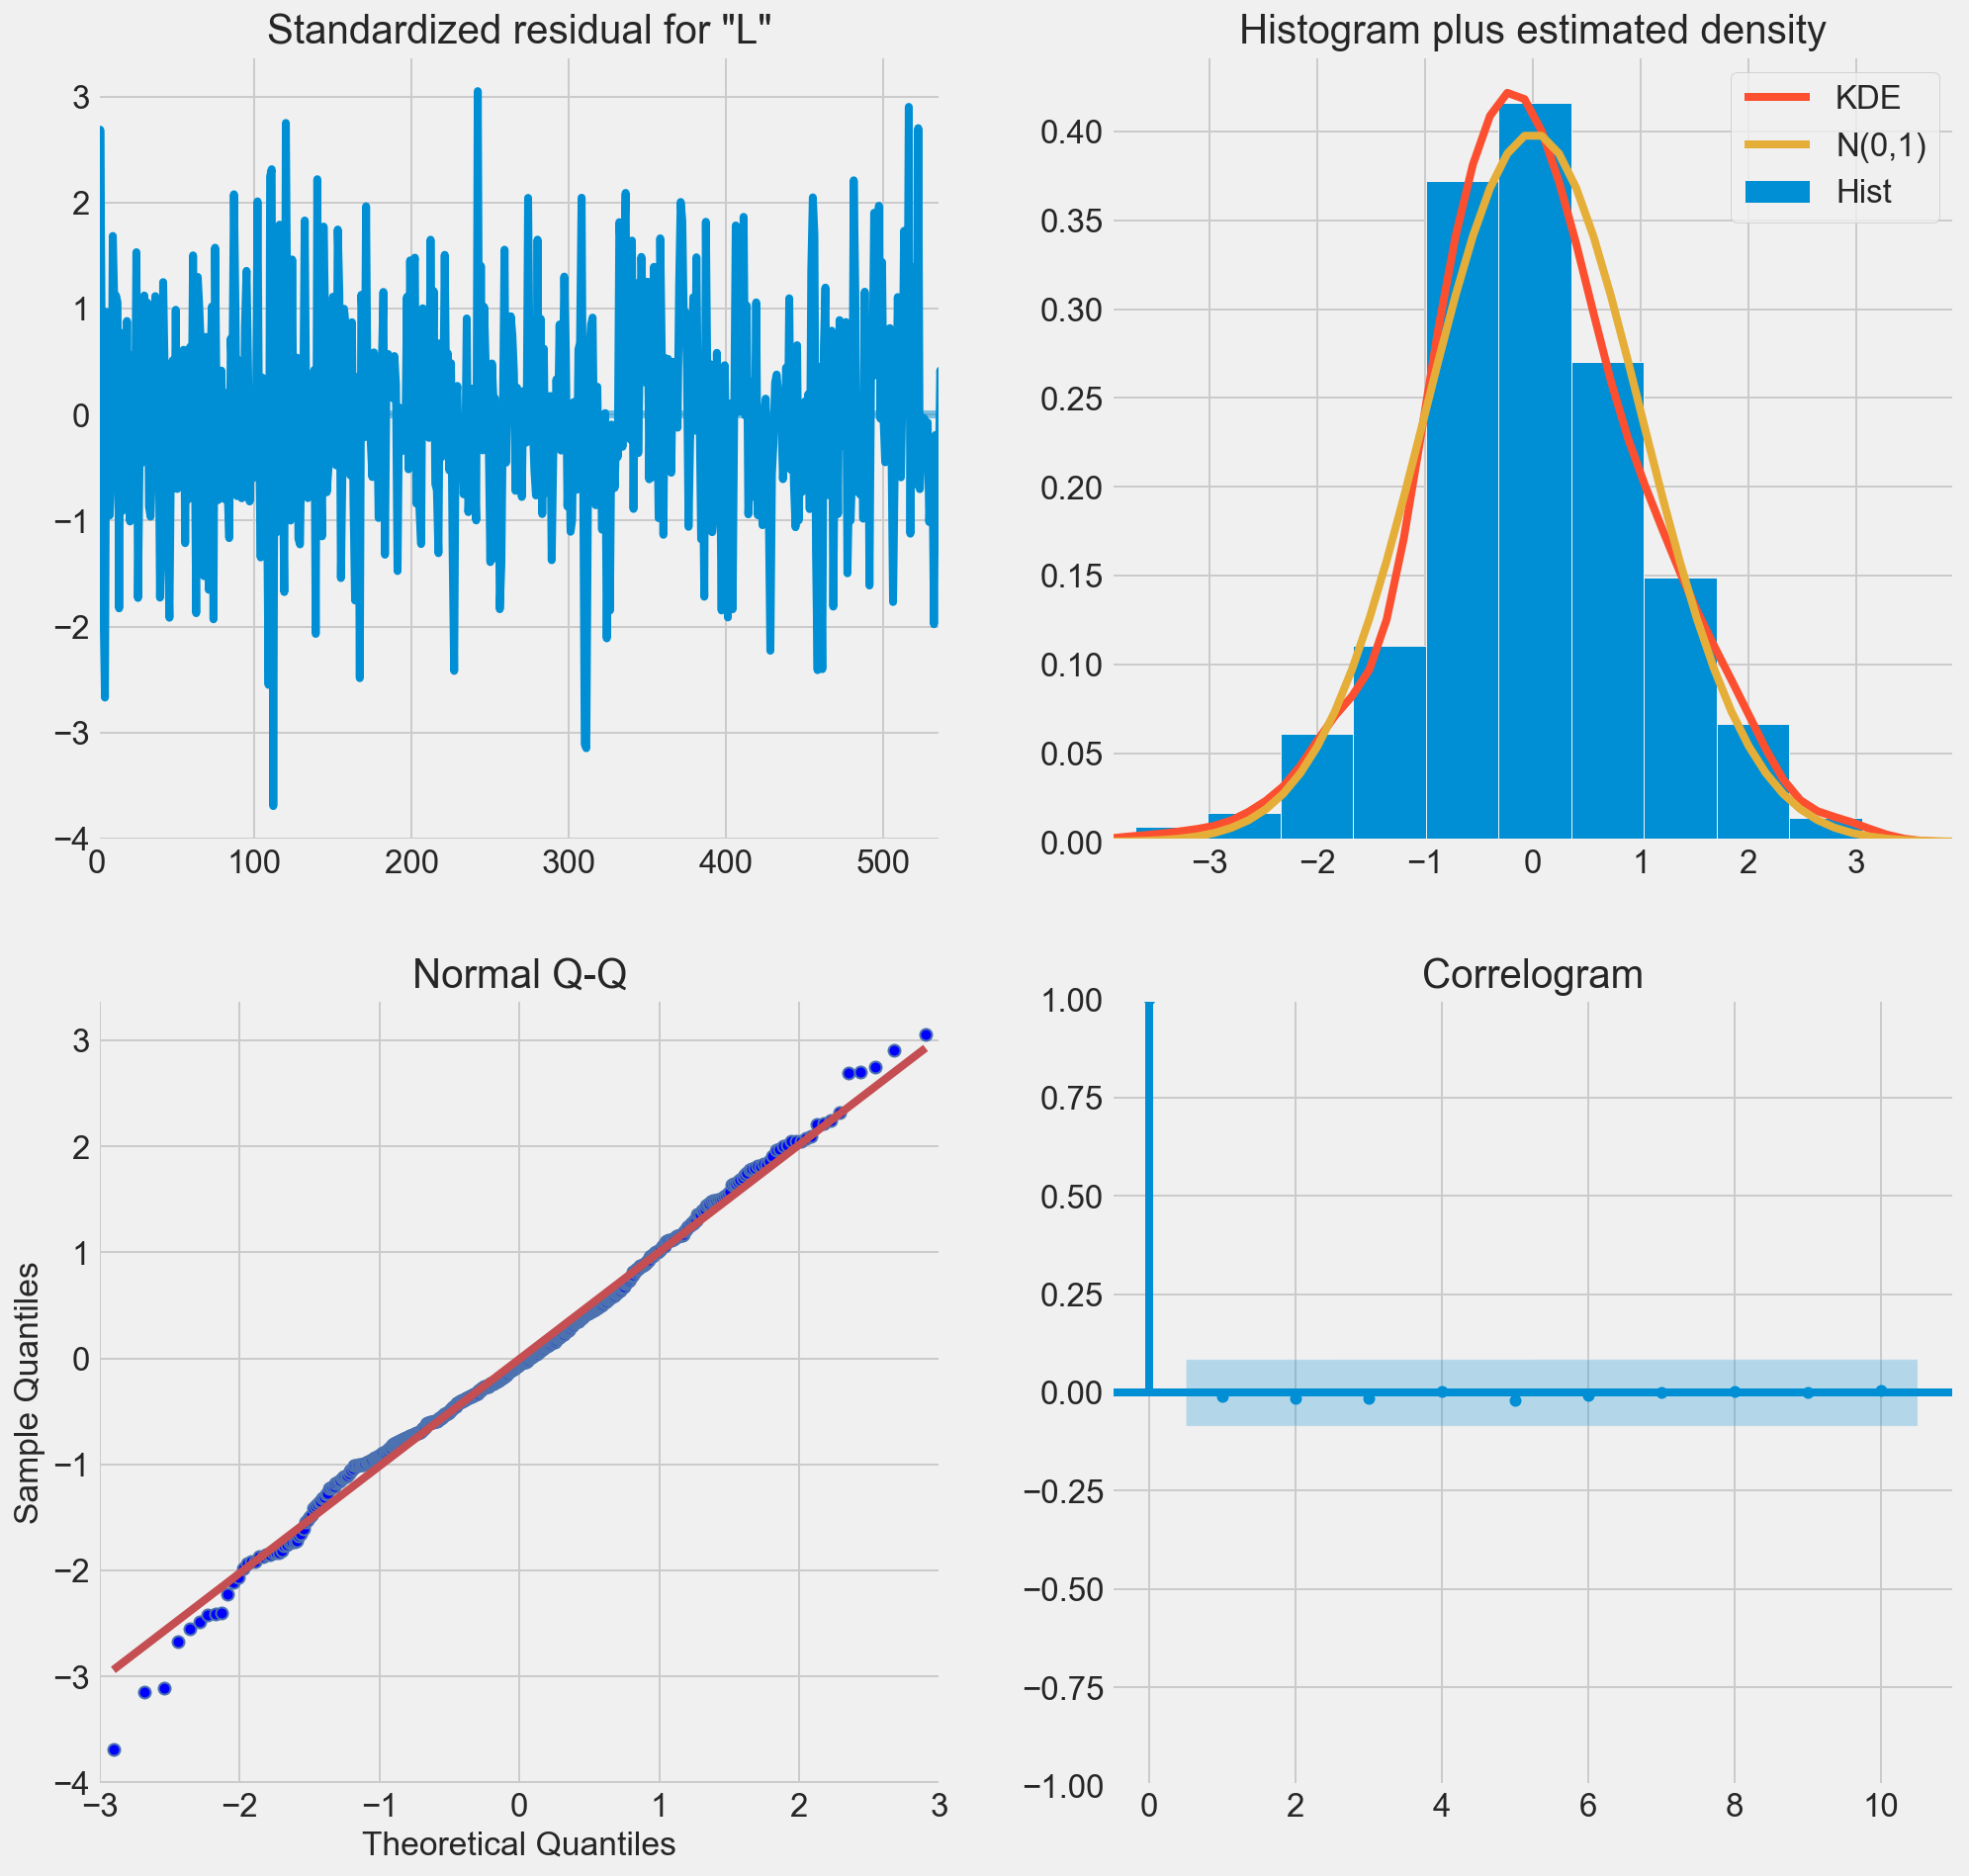

In [14]:
make_predict(data=buoy_data, buoy_id=35, feature='Longitude', order=(36, 2, 4),
              start_p=24, end_p=12, exog_features=['Significant Wave Height', 'Peak Direction', 'Current Direction'])